# Imports

In [1]:
from dqn_agent import DQNAgent
from ppo_agent import PPOAgent
from ffnn_agent import FFNNAgent
from data_processing import preprocess_all_data, load_preprocessed_dataset, get_activity, get_column_units, get_xy_from_data
from visualize import visualize_results, visualize_training, visualize_preprocessed_data
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load Data

In [2]:
# Load the preprocessed dataset
df = load_preprocessed_dataset()
target_features = ["Resting HR", "Max HR", "Age", "Weight", "Height"]

# Print unique values of target features
for feature in target_features:
    print(f"'{feature}' unique values: {df[feature].unique()}")

# Print unique values of 'Age'
print(f"\nUnique values of 'Age': {df['Age'].unique()}")

# Print how many rows there are for Activity ID 1 and 2
activity_counts = df['Activity ID'].value_counts()
print("\nActivity ID counts:")
for act_id in [1, 2]:
    count = activity_counts.get(act_id, 0)
    print(f"Activity ID {act_id}: {count} rows")

# Split based on Activity ID
df_val = df[df['Activity ID'] == 1].copy()
df_test = df[df['Activity ID'] == 2].copy()
df_train = df[~df['Activity ID'].isin([1, 2])].copy()

# Shuffle train set (optional but recommended)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Report split sizes
print(f"\nTrain samples (excluding Activity 1 & 2): {df_train.shape[0]}")
print(f"Validation samples (Activity 1): {df_val.shape[0]}")
print(f"Test samples (Activity 2): {df_test.shape[0]}")

# Get X and y splits
x_train, y_train = get_xy_from_data(df_train, target_features)
x_val, y_val = get_xy_from_data(df_val, target_features)
x_test, y_test = get_xy_from_data(df_test, target_features)

# Sanity check
print(f"\nX_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {x_test.shape}, y_test: {y_test.shape}")


---- Preprocessed Dataset Info ----
Number of rows: 61000
Number of columns: 39
-----------------------------------
'Resting HR' unique values: [75 74 68 58 70 60]
'Max HR' unique values: [193 195 189 196 194 197]
'Age' unique values: [27 25 31 24 26 23]
'Weight' unique values: [83 78 92 95 73 69 86]
'Height' unique values: [182 169 187 194 180 183 173]

Unique values of 'Age': [27 25 31 24 26 23]

Activity ID counts:
Activity ID 1: 7000 rows
Activity ID 2: 7000 rows

Train samples (excluding Activity 1 & 2): 47000
Validation samples (Activity 1): 7000
Test samples (Activity 2): 7000

X_train: (47000, 34), y_train: (47000, 5)
X_val: (7000, 34), y_val: (7000, 5)
X_test: (7000, 34), y_test: (7000, 5)


# Initialize system

In [3]:
continuous_columns = [
    'Timestamp',  'Hand Sensor - Temperature',
    'Hand Sensor - Accelerometer - X', 'Hand Sensor - Accelerometer - Y',
    'Hand Sensor - Accelerometer - Z', 'Hand Sensor - Gyroscope - X',
    'Hand Sensor - Gyroscope - Y', 'Hand Sensor - Gyroscope - Z',
    'Hand Sensor - Magnetometer - X', 'Hand Sensor - Magnetometer - Y',
    'Hand Sensor - Magnetometer - Z', 'Chest Sensor - Temperature',
    'Chest Sensor - Accelerometer - X', 'Chest Sensor - Accelerometer - Y',
    'Chest Sensor - Accelerometer - Z', 'Chest Sensor - Gyroscope - X',
    'Chest Sensor - Gyroscope - Y', 'Chest Sensor - Gyroscope - Z',
    'Chest Sensor - Magnetometer - X', 'Chest Sensor - Magnetometer - Y',
    'Chest Sensor - Magnetometer - Z', 'Ankle Sensor - Temperature',
    'Ankle Sensor - Accelerometer - X', 'Ankle Sensor - Accelerometer - Y',
    'Ankle Sensor - Accelerometer - Z', 'Ankle Sensor - Gyroscope - X',
    'Ankle Sensor - Gyroscope - Y', 'Ankle Sensor - Gyroscope - Z',
    'Ankle Sensor - Magnetometer - X', 'Ankle Sensor - Magnetometer - Y',
    'Ankle Sensor - Magnetometer - Z'
]

discrete_columns = [
     'Sex - Female', 'Heart Rate', "Resting HR", "Max HR", "Weight", "Height"
]

#discrete action size columns
dqn_config = {
    'state_size': 5,  
    'action_size': len(discrete_columns),  
    'hidden_size': 64,
    'lr': 1e-3,
    'gamma': 0.9995,
    'batch_size': 64,
    'memory_size': 10000,
    'epsilon_start': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.995
}


#continuous
ppo_config = {
    'state_size': 5,  
    'action_size': len(continuous_columns),   
    'hidden_size': 64,
    'lr': 1e-3,
    'gamma': 0.9995,
    'clip_epsilon': 0.2,
    'update_epochs': 10,
    'batch_size': 64,
    'c1': 0.5,
    'c2': 0.01
}
classes = [1, 2, 3, 17, 16, 13, 4, 7, 6]

ffnn_config = {
    'input_size': df.shape[1] - 5,
    'hidden_sizes': [16, 16],
    'output_size': 5,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 20,
    'type': 'regression',
    'classes': None
}

accuracy_reward_multiplier = 10

synthetic_data_amount = 1000
num_episodes = 100

dqn_agent = DQNAgent(**dqn_config)
ppo_agent = PPOAgent(**ppo_config)
ffnn_agent = FFNNAgent(**ffnn_config)
ffnn_agent_og = FFNNAgent(**ffnn_config)

Using device: cuda
Using device: cuda


# Training


Training FFNN on real data only (no synthetic data)...


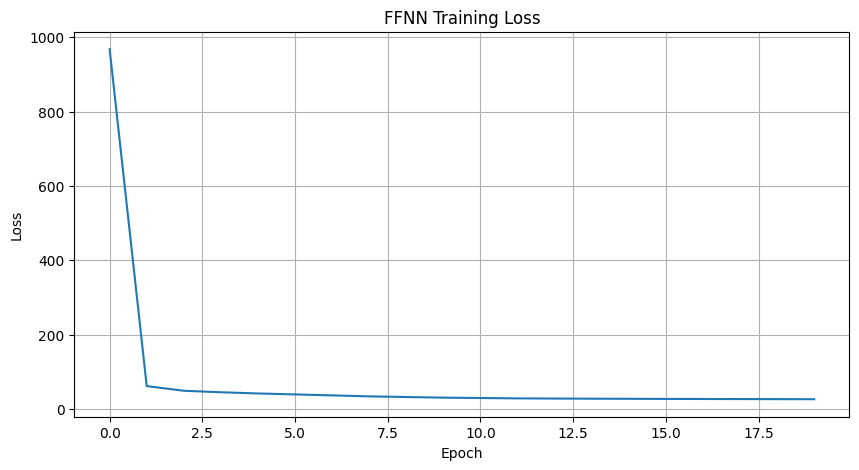


========== FFNN Baseline (No Synthetic Data) ==========
Train MSE: 25.6154 | Train MAE: 3.7593 | Female MSE: 4.9185
Val   MSE: 70.5680 | Val   MAE: 6.1431 | Female MSE: 18.6914
Test  MSE: 51.8583 | Test  MAE: 5.0654 | Female MSE: 2.6391

Episode 1/100: Generating Synthetic Data
Episode 1/100: Training FFNN


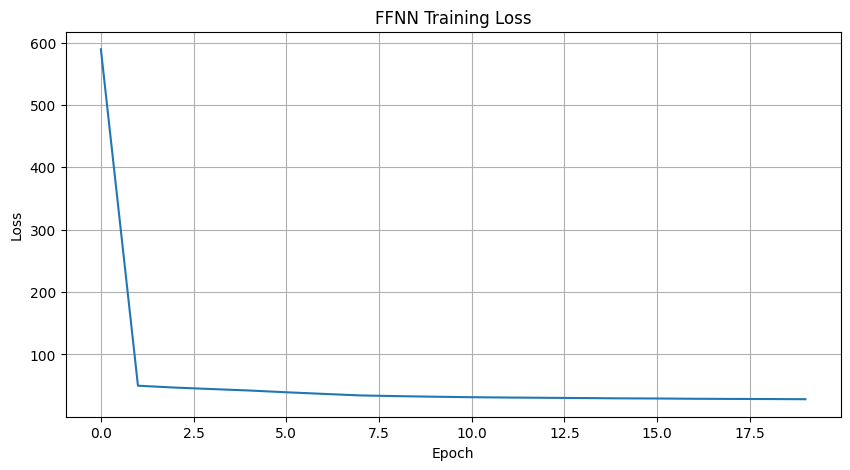

Episode 1/100: Evaluating FFNN
Episode 1/100 | Reward: -2314.8505
Train MSE: 28.7084 | Train Female MSE: 6.2872
Val MSE: 234.8330 | Val Female MSE: 21.1832
Test MSE: 50.6763 | Test Female MSE: 2.9511

--------------------------------

Episode 2/100: Generating Synthetic Data
Episode 2/100: Training FFNN


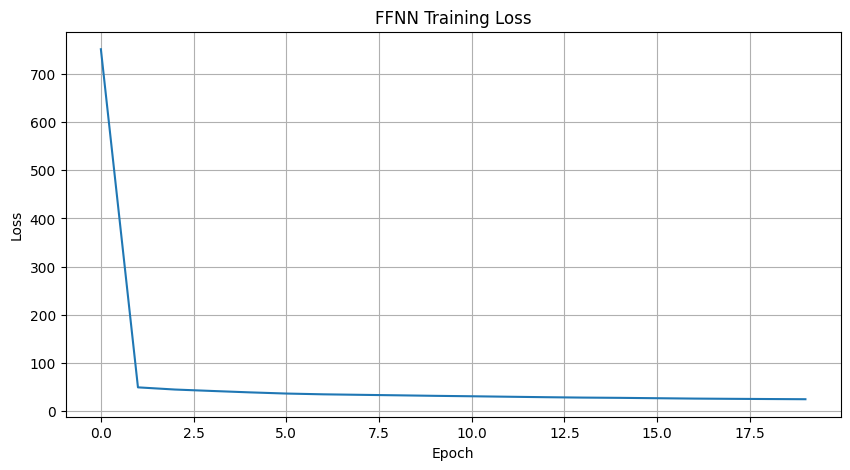

Episode 2/100: Evaluating FFNN
Episode 2/100 | Reward: -1375.8268
Train MSE: 24.1114 | Train Female MSE: 4.1461
Val MSE: 141.3637 | Val Female MSE: 5.6991
Test MSE: 65.0079 | Test Female MSE: 2.9230

--------------------------------

Episode 3/100: Generating Synthetic Data
Episode 3/100: Training FFNN


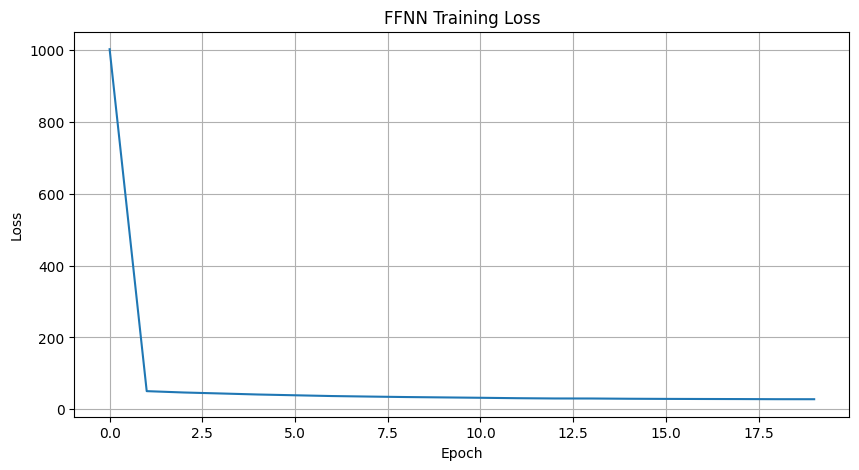

Episode 3/100: Evaluating FFNN
Episode 3/100 | Reward: -888.0846
Train MSE: 28.0904 | Train Female MSE: 5.7059
Val MSE: 91.9829 | Val Female MSE: 15.1092
Test MSE: 49.2230 | Test Female MSE: 3.1621

--------------------------------

Episode 4/100: Generating Synthetic Data
Episode 4/100: Training FFNN


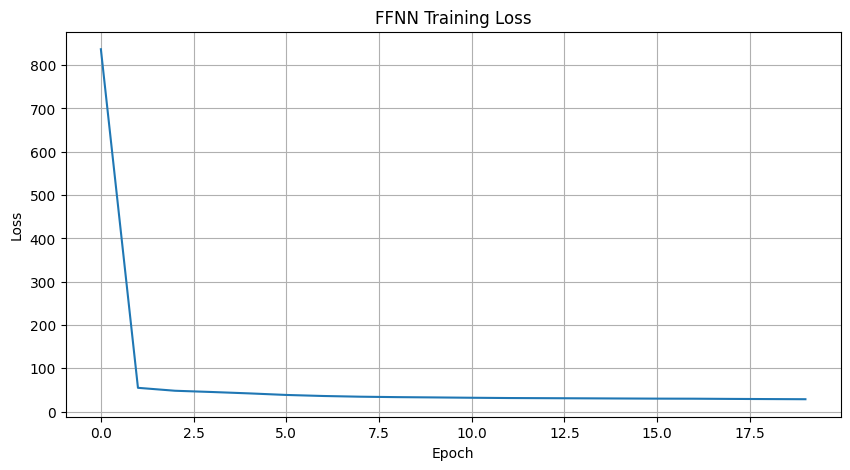

Episode 4/100: Evaluating FFNN
Episode 4/100 | Reward: -1370.7666
Train MSE: 28.1597 | Train Female MSE: 5.8730
Val MSE: 140.2935 | Val Female MSE: 38.9735
Test MSE: 56.2129 | Test Female MSE: 10.5859

--------------------------------

Episode 5/100: Generating Synthetic Data
Episode 5/100: Training FFNN


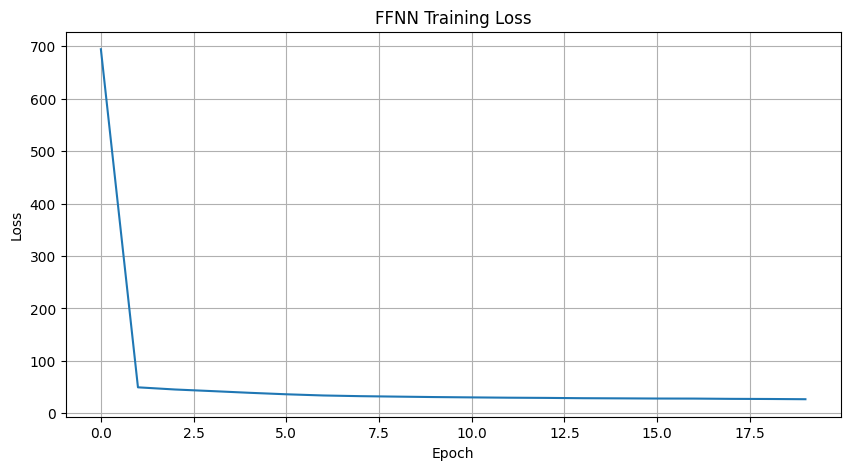

Episode 5/100: Evaluating FFNN
Episode 5/100 | Reward: -3185.5238
Train MSE: 30.6726 | Train Female MSE: 9.8285
Val MSE: 321.6601 | Val Female MSE: 89.7282
Test MSE: 69.6324 | Test Female MSE: 7.4141

--------------------------------

Episode 6/100: Generating Synthetic Data
Episode 6/100: Training FFNN


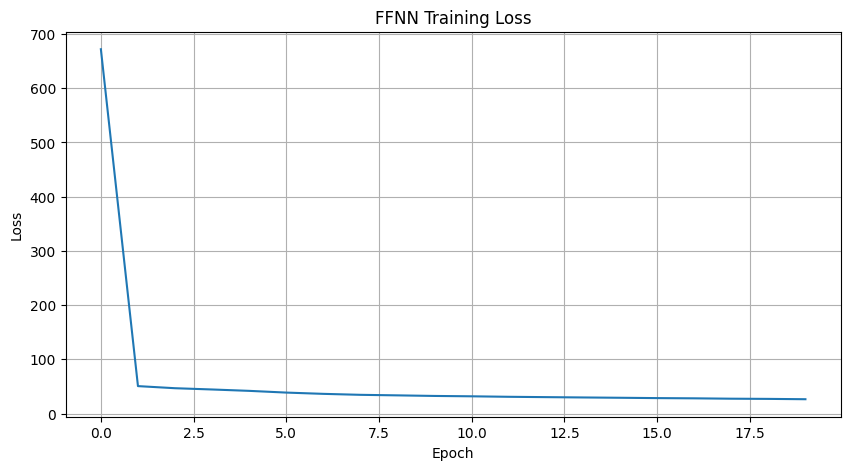

Episode 6/100: Evaluating FFNN
Episode 6/100 | Reward: -2015.3581
Train MSE: 25.8852 | Train Female MSE: 6.5326
Val MSE: 204.6662 | Val Female MSE: 115.2572
Test MSE: 60.1706 | Test Female MSE: 14.9973

--------------------------------

Episode 7/100: Generating Synthetic Data
Episode 7/100: Training FFNN


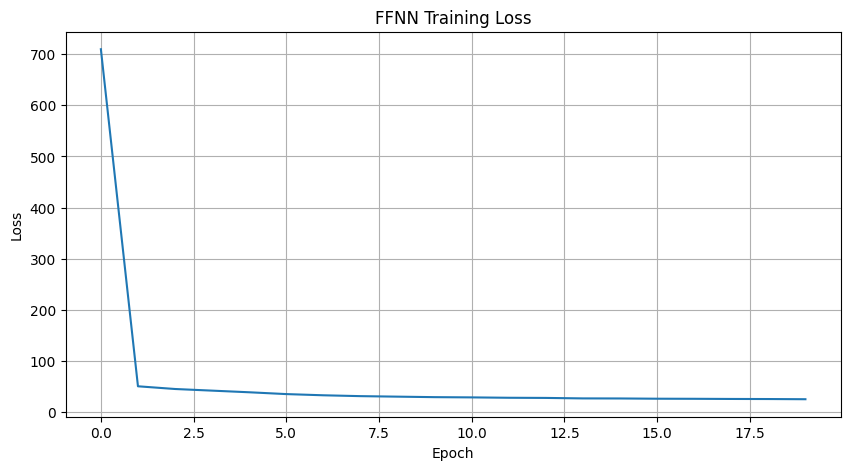

Episode 7/100: Evaluating FFNN
Episode 7/100 | Reward: -3890.5588
Train MSE: 26.0083 | Train Female MSE: 7.3175
Val MSE: 392.3679 | Val Female MSE: 78.4916
Test MSE: 57.9366 | Test Female MSE: 14.6949

--------------------------------

Episode 8/100: Generating Synthetic Data
Episode 8/100: Training FFNN


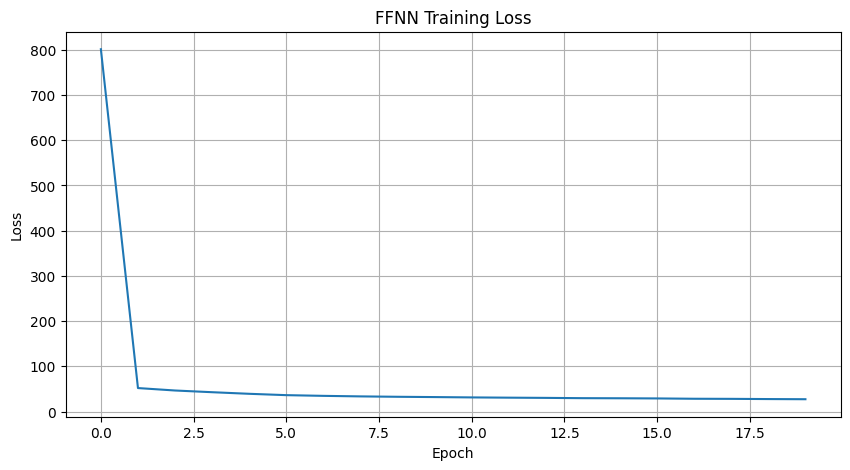

Episode 8/100: Evaluating FFNN
Episode 8/100 | Reward: -2258.8284
Train MSE: 28.1506 | Train Female MSE: 6.1653
Val MSE: 229.1822 | Val Female MSE: 85.3510
Test MSE: 64.3527 | Test Female MSE: 7.0612

--------------------------------

Episode 9/100: Generating Synthetic Data
Episode 9/100: Training FFNN


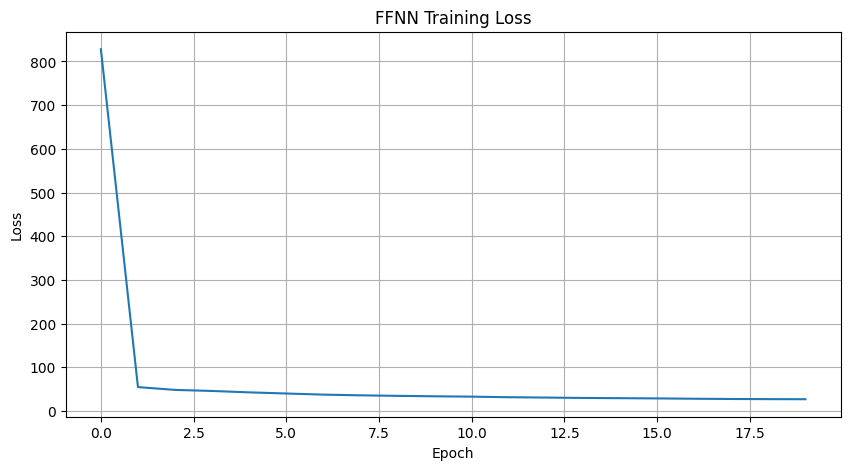

Episode 9/100: Evaluating FFNN
Episode 9/100 | Reward: -696.4944
Train MSE: 26.5977 | Train Female MSE: 6.0978
Val MSE: 73.1733 | Val Female MSE: 8.0522
Test MSE: 93.9749 | Test Female MSE: 26.0718

--------------------------------

Episode 10/100: Generating Synthetic Data
Episode 10/100: Training FFNN


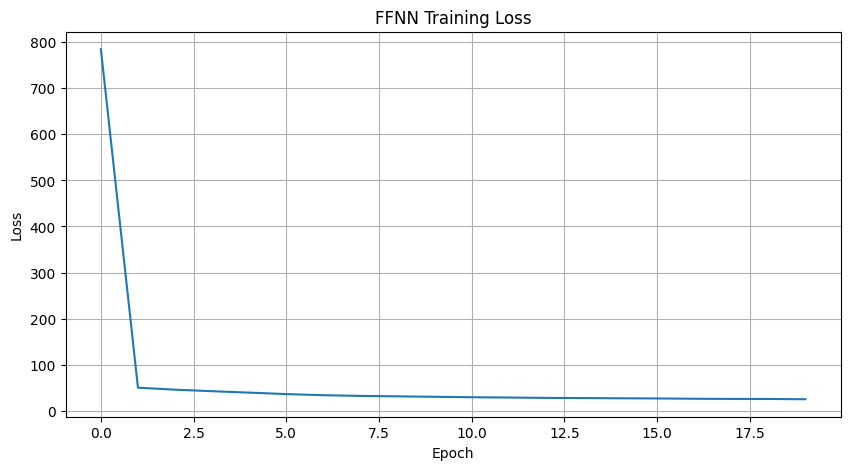

Episode 10/100: Evaluating FFNN
Episode 10/100 | Reward: -1376.2594
Train MSE: 24.7180 | Train Female MSE: 5.2935
Val MSE: 141.9572 | Val Female MSE: 62.9151
Test MSE: 59.8561 | Test Female MSE: 9.2925

--------------------------------

Episode 11/100: Generating Synthetic Data
Episode 11/100: Training FFNN


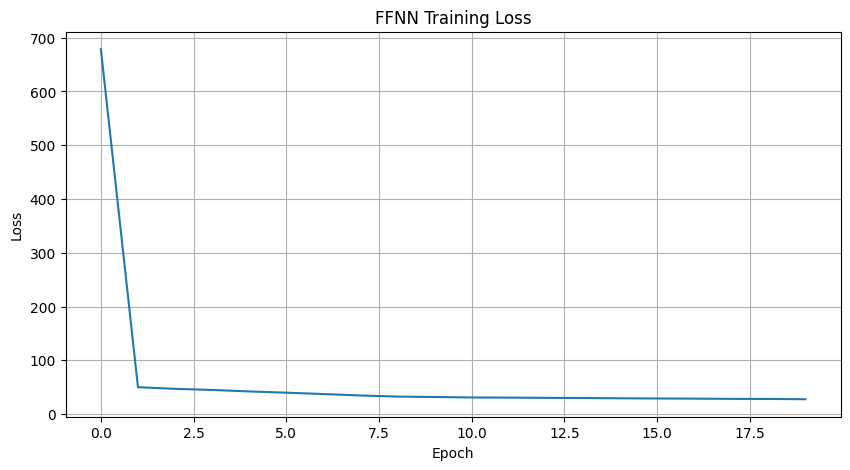

Episode 11/100: Evaluating FFNN
Episode 11/100 | Reward: -4610.0916
Train MSE: 26.8656 | Train Female MSE: 5.4424
Val MSE: 465.2202 | Val Female MSE: 123.2621
Test MSE: 51.1936 | Test Female MSE: 2.7274

--------------------------------

Episode 12/100: Generating Synthetic Data
Episode 12/100: Training FFNN


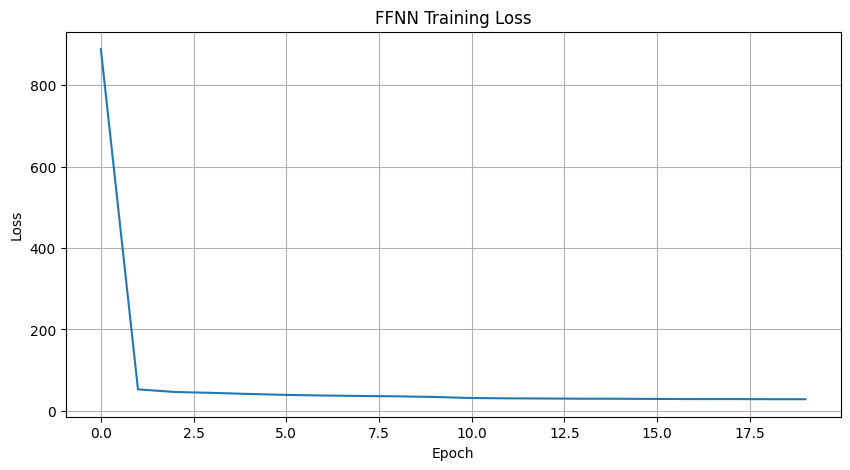

Episode 12/100: Evaluating FFNN
Episode 12/100 | Reward: -1310.3137
Train MSE: 27.7370 | Train Female MSE: 6.4529
Val MSE: 135.1282 | Val Female MSE: 23.1227
Test MSE: 59.7197 | Test Female MSE: 6.0084

--------------------------------

Episode 13/100: Generating Synthetic Data
Episode 13/100: Training FFNN


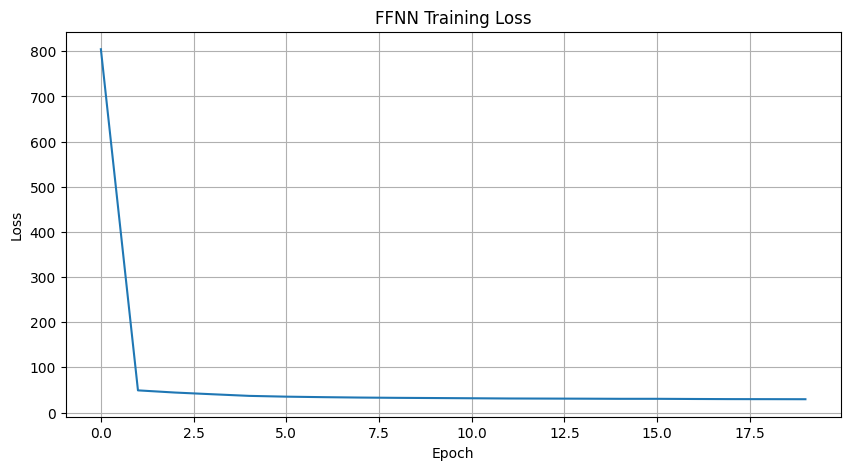

Episode 13/100: Evaluating FFNN
Episode 13/100 | Reward: -3076.3017
Train MSE: 28.7395 | Train Female MSE: 6.1811
Val MSE: 311.6537 | Val Female MSE: 22.1491
Test MSE: 43.4866 | Test Female MSE: 6.9456

--------------------------------

Episode 14/100: Generating Synthetic Data
Episode 14/100: Training FFNN


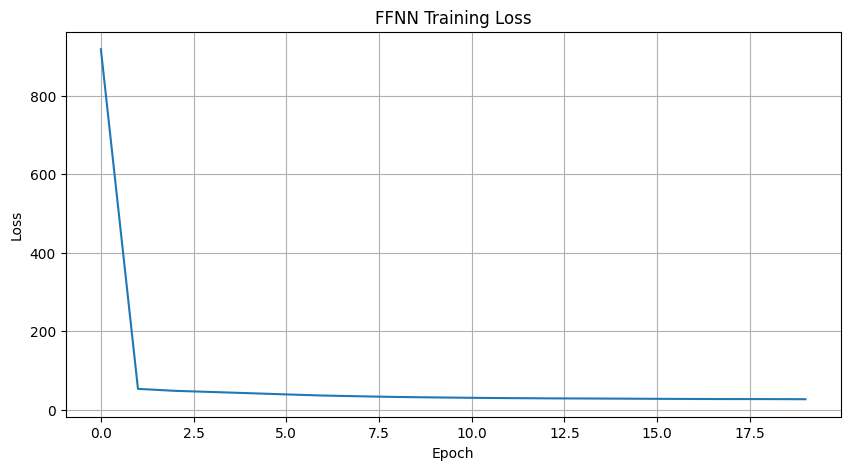

Episode 14/100: Evaluating FFNN
Episode 14/100 | Reward: -1052.7452
Train MSE: 25.9726 | Train Female MSE: 6.2391
Val MSE: 109.2342 | Val Female MSE: 10.1921
Test MSE: 59.5802 | Test Female MSE: 6.5258

--------------------------------

Episode 15/100: Generating Synthetic Data
Episode 15/100: Training FFNN


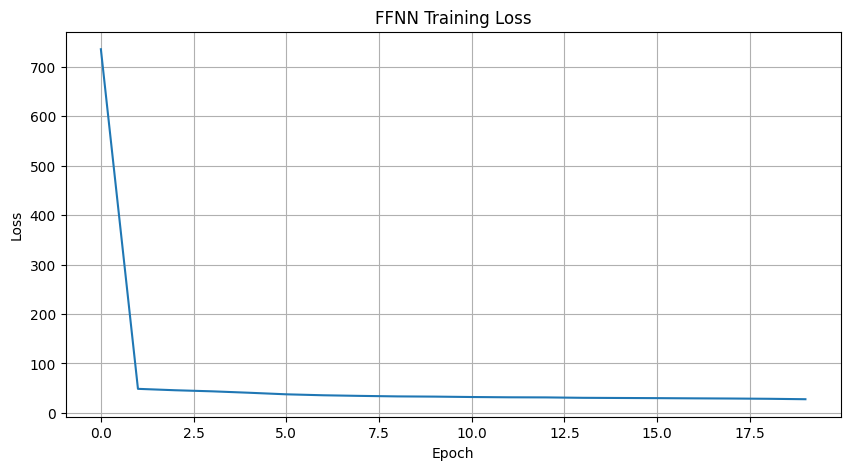

Episode 15/100: Evaluating FFNN
Episode 15/100 | Reward: -1126.3324
Train MSE: 28.2547 | Train Female MSE: 6.0887
Val MSE: 117.1815 | Val Female MSE: 16.6514
Test MSE: 49.9463 | Test Female MSE: 3.8501

--------------------------------

Episode 16/100: Generating Synthetic Data
Episode 16/100: Training FFNN


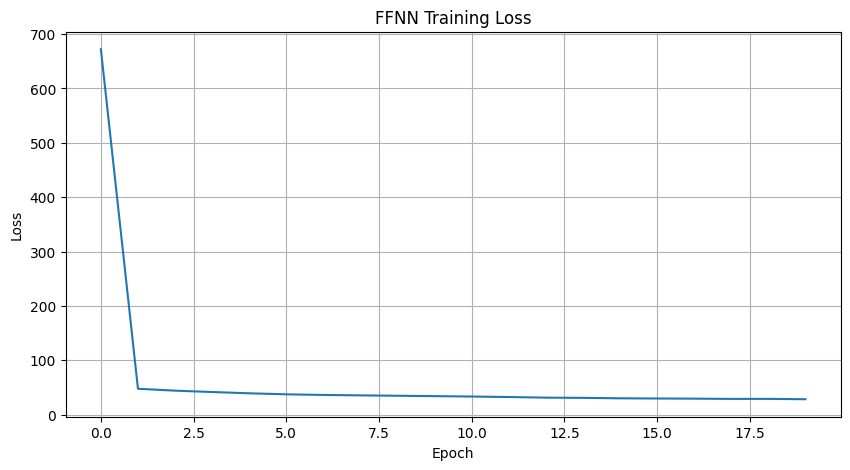

Episode 16/100: Evaluating FFNN
Episode 16/100 | Reward: -1202.4301
Train MSE: 28.4909 | Train Female MSE: 6.0625
Val MSE: 124.6376 | Val Female MSE: 74.2874
Test MSE: 73.8591 | Test Female MSE: 26.1788

--------------------------------

Episode 17/100: Generating Synthetic Data
Episode 17/100: Training FFNN


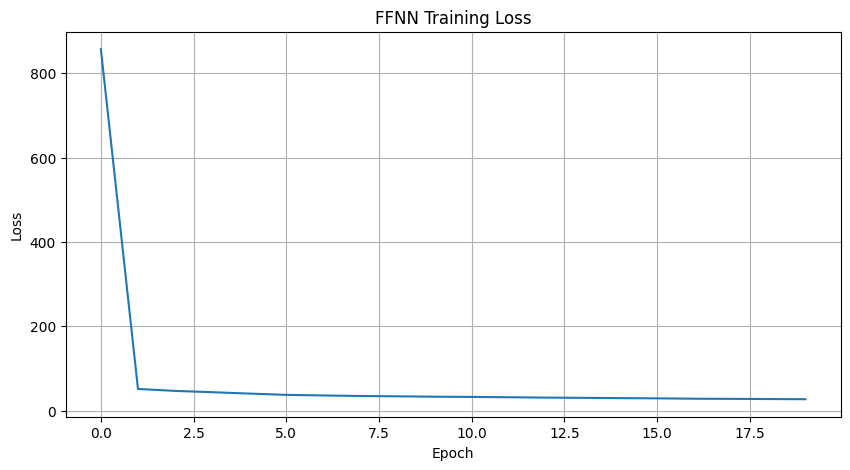

Episode 17/100: Evaluating FFNN
Episode 17/100 | Reward: -1921.9994
Train MSE: 25.6484 | Train Female MSE: 5.3067
Val MSE: 196.5480 | Val Female MSE: 21.1473
Test MSE: 56.7422 | Test Female MSE: 4.9586

--------------------------------

Episode 18/100: Generating Synthetic Data
Episode 18/100: Training FFNN


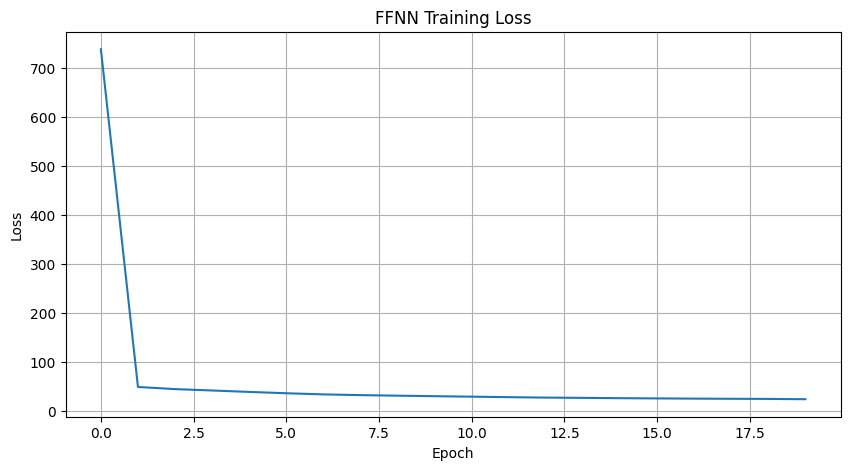

Episode 18/100: Evaluating FFNN
Episode 18/100 | Reward: -646.9372
Train MSE: 23.0682 | Train Female MSE: 5.0323
Val MSE: 68.7640 | Val Female MSE: 21.0333
Test MSE: 99.9321 | Test Female MSE: 36.8963

--------------------------------

Episode 19/100: Generating Synthetic Data
Episode 19/100: Training FFNN


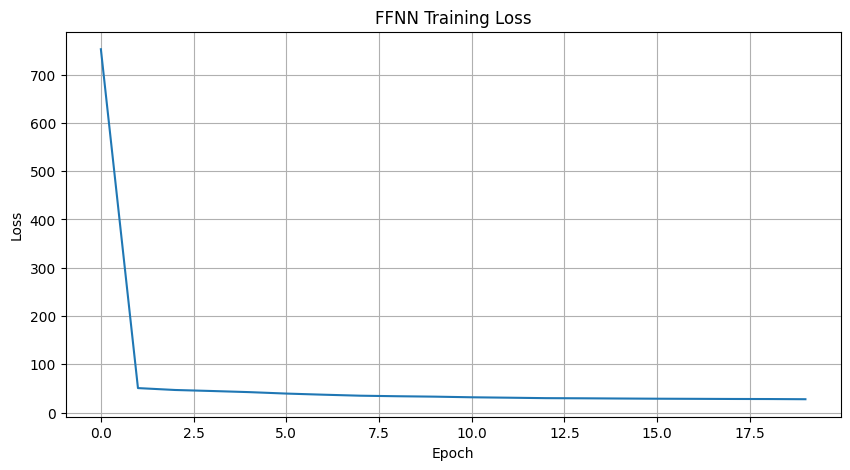

Episode 19/100: Evaluating FFNN
Episode 19/100 | Reward: -770.8955
Train MSE: 28.9077 | Train Female MSE: 8.2999
Val MSE: 80.8686 | Val Female MSE: 21.2993
Test MSE: 79.3229 | Test Female MSE: 29.4230

--------------------------------

Episode 20/100: Generating Synthetic Data
Episode 20/100: Training FFNN


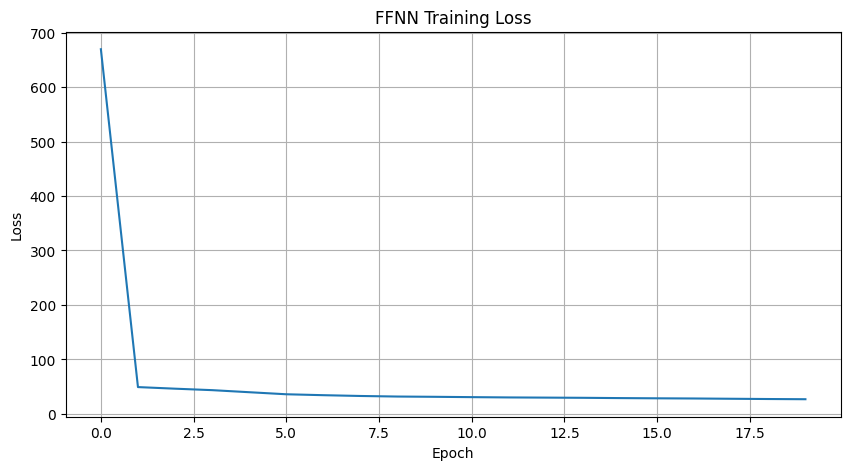

Episode 20/100: Evaluating FFNN
Episode 20/100 | Reward: -2640.2658
Train MSE: 26.7742 | Train Female MSE: 6.8515
Val MSE: 267.8463 | Val Female MSE: 68.5568
Test MSE: 59.6983 | Test Female MSE: 5.8802

--------------------------------

Episode 21/100: Generating Synthetic Data
Episode 21/100: Training FFNN


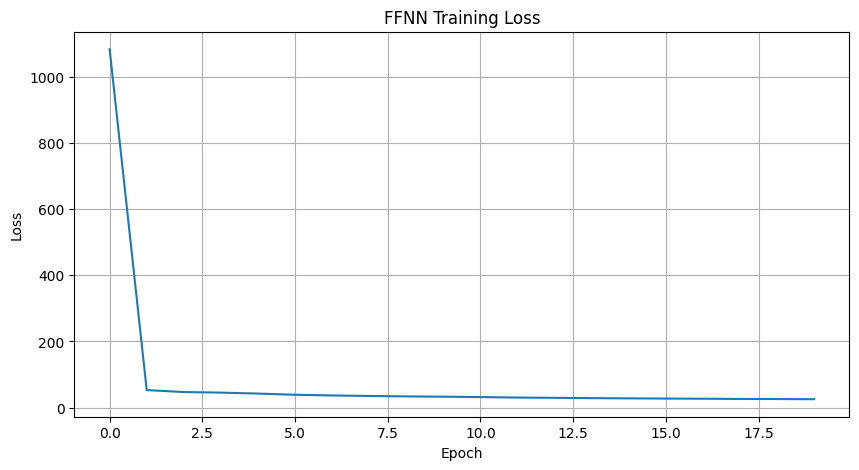

Episode 21/100: Evaluating FFNN
Episode 21/100 | Reward: -822.7013
Train MSE: 24.3576 | Train Female MSE: 5.0384
Val MSE: 86.0480 | Val Female MSE: 65.0252
Test MSE: 47.5340 | Test Female MSE: 4.3880

--------------------------------

Episode 22/100: Generating Synthetic Data
Episode 22/100: Training FFNN


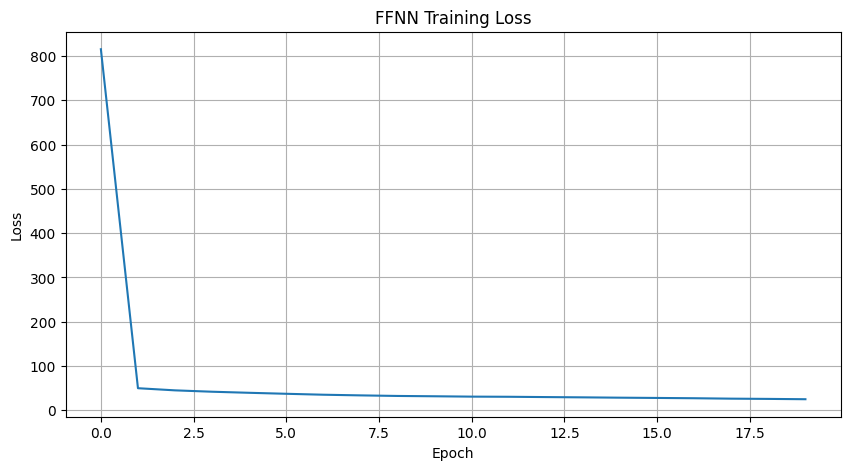

Episode 22/100: Evaluating FFNN
Episode 22/100 | Reward: -2232.2271
Train MSE: 24.5054 | Train Female MSE: 5.1920
Val MSE: 227.1131 | Val Female MSE: 228.2014
Test MSE: 57.0493 | Test Female MSE: 31.2150

--------------------------------

Episode 23/100: Generating Synthetic Data
Episode 23/100: Training FFNN


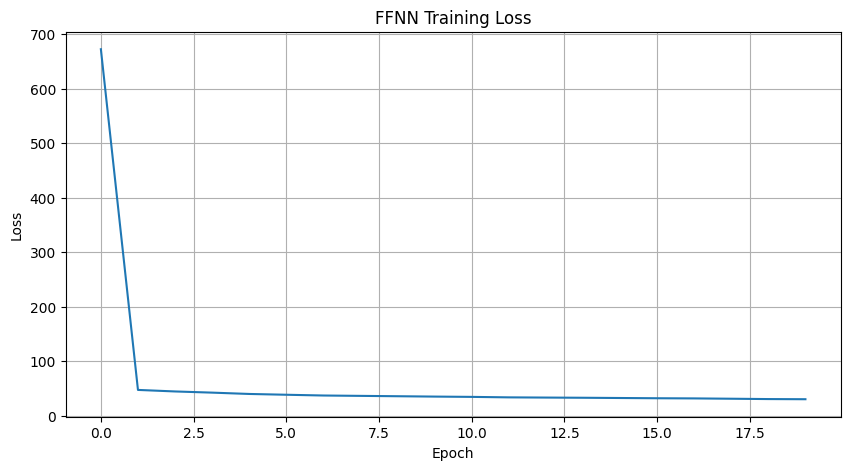

Episode 23/100: Evaluating FFNN
Episode 23/100 | Reward: -2287.3106
Train MSE: 34.8983 | Train Female MSE: 11.6132
Val MSE: 232.4561 | Val Female MSE: 43.0175
Test MSE: 39.0498 | Test Female MSE: 8.7514

--------------------------------

Episode 24/100: Generating Synthetic Data
Episode 24/100: Training FFNN


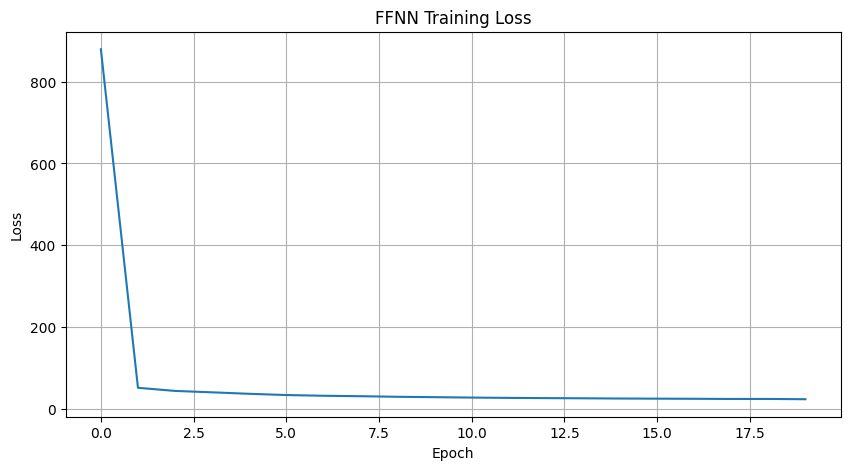

Episode 24/100: Evaluating FFNN
Episode 24/100 | Reward: -850.7630
Train MSE: 23.5845 | Train Female MSE: 5.9344
Val MSE: 88.7734 | Val Female MSE: 61.1441
Test MSE: 70.5021 | Test Female MSE: 17.5222

--------------------------------

Episode 25/100: Generating Synthetic Data
Episode 25/100: Training FFNN


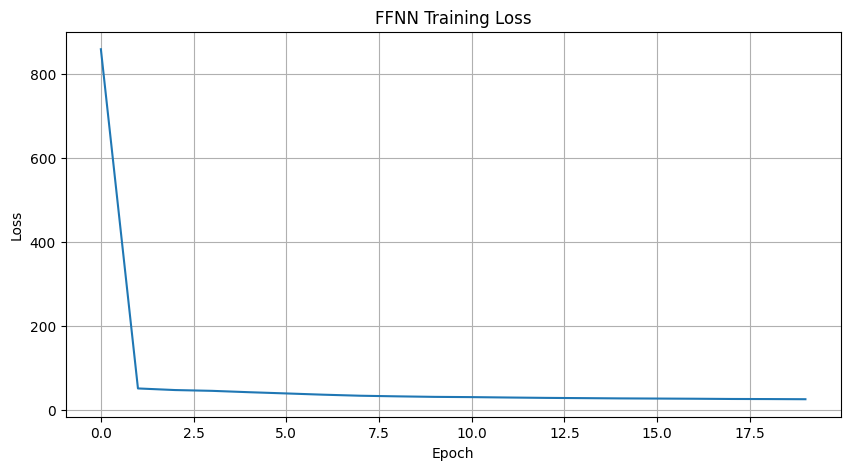

Episode 25/100: Evaluating FFNN
Episode 25/100 | Reward: -1373.5713
Train MSE: 24.7712 | Train Female MSE: 5.6833
Val MSE: 141.0758 | Val Female MSE: 40.3086
Test MSE: 64.2941 | Test Female MSE: 10.1429

--------------------------------

Episode 26/100: Generating Synthetic Data
Episode 26/100: Training FFNN


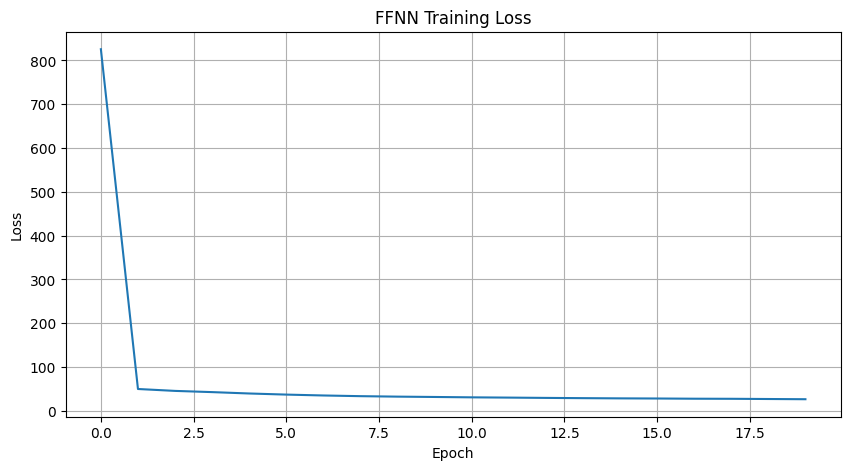

Episode 26/100: Evaluating FFNN
Episode 26/100 | Reward: -1061.0003
Train MSE: 28.5962 | Train Female MSE: 7.3715
Val MSE: 111.3683 | Val Female MSE: 46.9147
Test MSE: 58.1196 | Test Female MSE: 14.4908

--------------------------------

Episode 27/100: Generating Synthetic Data
Episode 27/100: Training FFNN


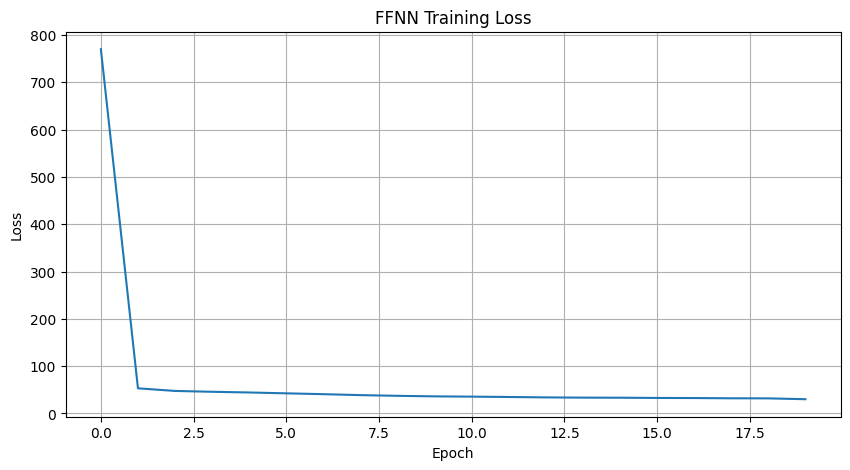

Episode 27/100: Evaluating FFNN
Episode 27/100 | Reward: -1610.4633
Train MSE: 29.8066 | Train Female MSE: 6.5095
Val MSE: 165.7609 | Val Female MSE: 109.8279
Test MSE: 69.1056 | Test Female MSE: 18.0424

--------------------------------

Episode 28/100: Generating Synthetic Data
Episode 28/100: Training FFNN


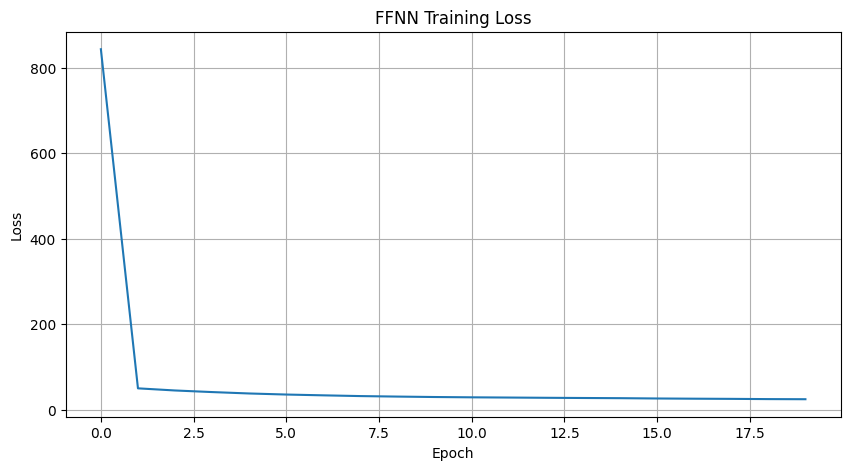

Episode 28/100: Evaluating FFNN
Episode 28/100 | Reward: -1240.8933
Train MSE: 26.0911 | Train Female MSE: 7.5210
Val MSE: 130.1361 | Val Female MSE: 22.1268
Test MSE: 36.2155 | Test Female MSE: 7.6515

--------------------------------

Episode 29/100: Generating Synthetic Data
Episode 29/100: Training FFNN


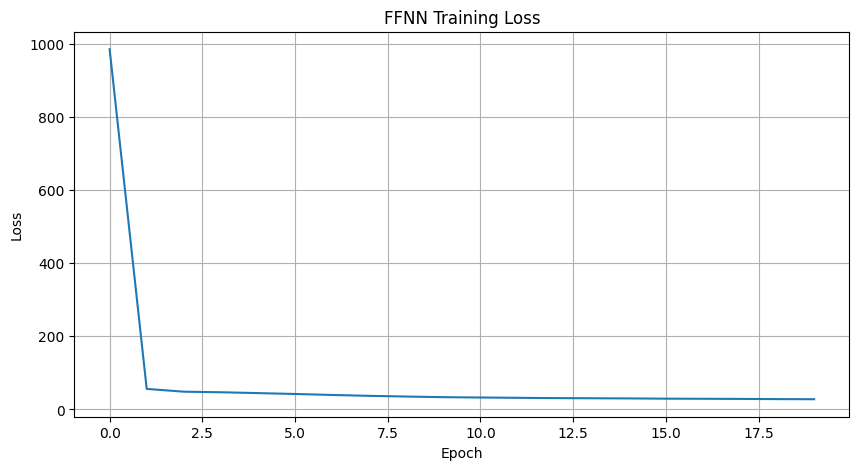

Episode 29/100: Evaluating FFNN
Episode 29/100 | Reward: -564.6510
Train MSE: 28.0890 | Train Female MSE: 7.8131
Val MSE: 62.2465 | Val Female MSE: 9.1280
Test MSE: 42.3690 | Test Female MSE: 10.0960

--------------------------------

Episode 30/100: Generating Synthetic Data
Episode 30/100: Training FFNN


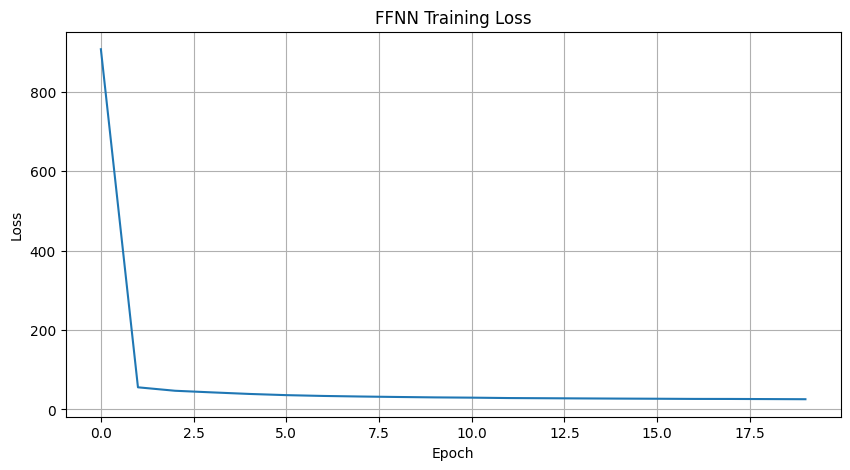

Episode 30/100: Evaluating FFNN
Episode 30/100 | Reward: -964.8610
Train MSE: 28.5766 | Train Female MSE: 10.0111
Val MSE: 102.7785 | Val Female MSE: 4.9220
Test MSE: 55.2401 | Test Female MSE: 18.6675

--------------------------------

Episode 31/100: Generating Synthetic Data
Episode 31/100: Training FFNN


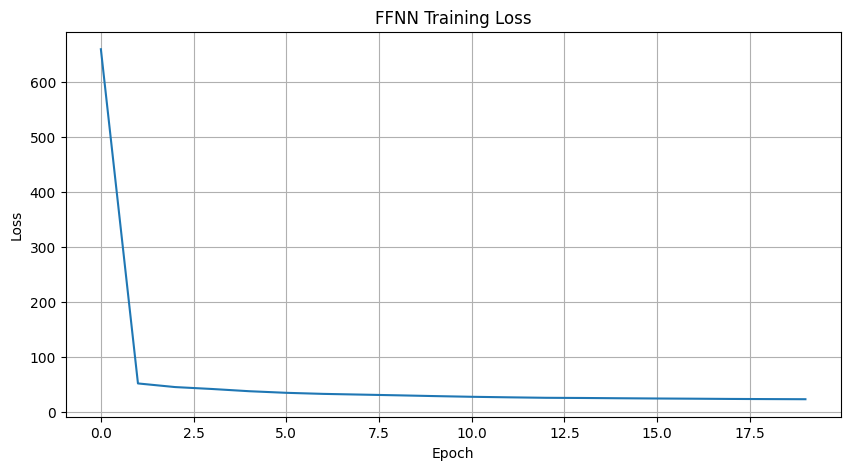

Episode 31/100: Evaluating FFNN
Episode 31/100 | Reward: -935.7923
Train MSE: 22.8098 | Train Female MSE: 5.1049
Val MSE: 100.3385 | Val Female MSE: 41.3836
Test MSE: 61.1199 | Test Female MSE: 6.7847

--------------------------------

Episode 32/100: Generating Synthetic Data
Episode 32/100: Training FFNN


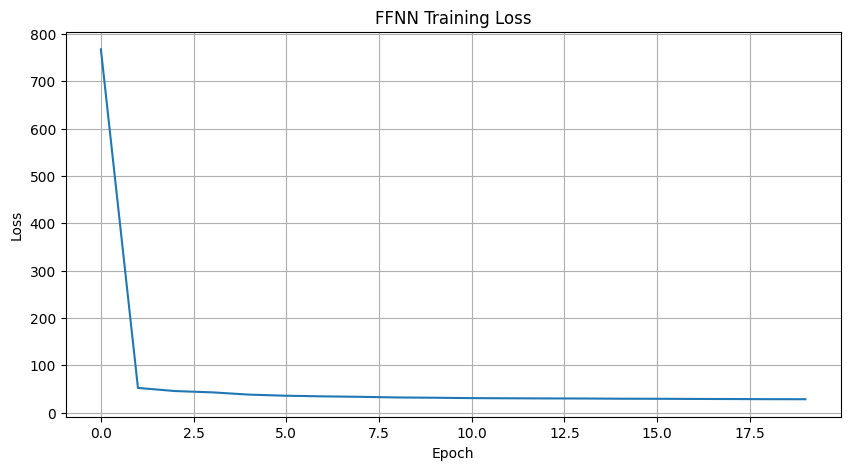

Episode 32/100: Evaluating FFNN
Episode 32/100 | Reward: -1280.7593
Train MSE: 35.5674 | Train Female MSE: 11.5721
Val MSE: 135.3604 | Val Female MSE: 147.6367
Test MSE: 59.1824 | Test Female MSE: 9.8858

--------------------------------

Episode 33/100: Generating Synthetic Data
Episode 33/100: Training FFNN


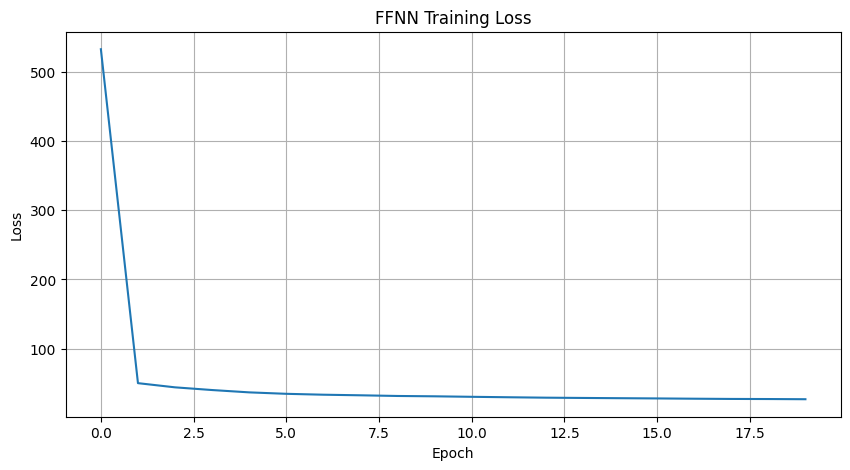

Episode 33/100: Evaluating FFNN
Episode 33/100 | Reward: -847.1943
Train MSE: 27.0395 | Train Female MSE: 8.8856
Val MSE: 91.6810 | Val Female MSE: 14.1739
Test MSE: 57.1180 | Test Female MSE: 8.6628

--------------------------------

Episode 34/100: Generating Synthetic Data
Episode 34/100: Training FFNN


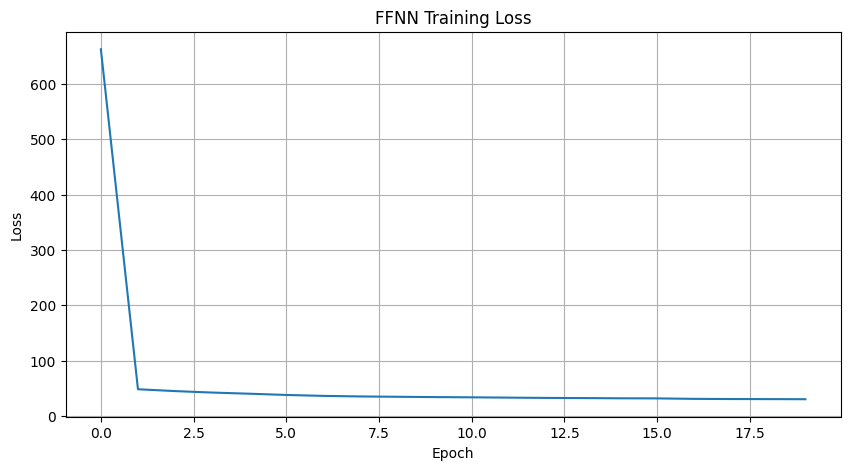

Episode 34/100: Evaluating FFNN
Episode 34/100 | Reward: -1242.4314
Train MSE: 29.8813 | Train Female MSE: 7.1742
Val MSE: 130.8542 | Val Female MSE: 14.3385
Test MSE: 46.2531 | Test Female MSE: 11.9836

--------------------------------

Episode 35/100: Generating Synthetic Data
Episode 35/100: Training FFNN


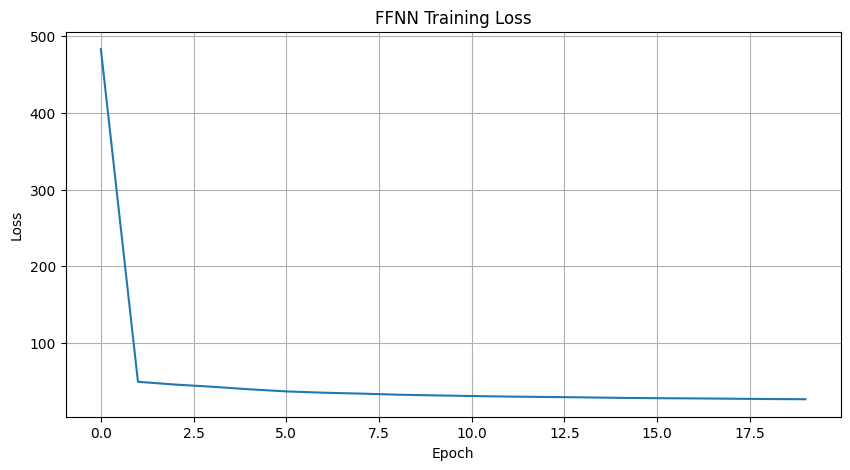

Episode 35/100: Evaluating FFNN
Episode 35/100 | Reward: -1189.3636
Train MSE: 25.9595 | Train Female MSE: 5.1157
Val MSE: 125.5779 | Val Female MSE: 56.3116
Test MSE: 52.8058 | Test Female MSE: 6.9217

--------------------------------

Episode 36/100: Generating Synthetic Data
Episode 36/100: Training FFNN


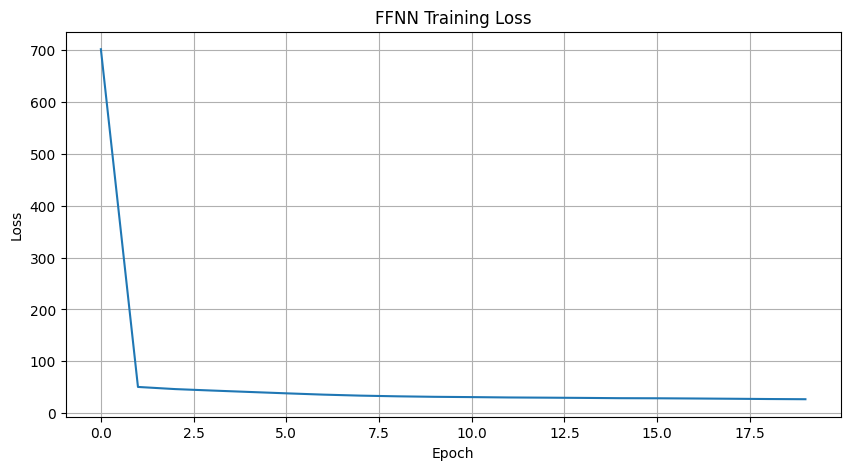

Episode 36/100: Evaluating FFNN
Episode 36/100 | Reward: -2261.9914
Train MSE: 26.3358 | Train Female MSE: 6.1702
Val MSE: 232.8259 | Val Female MSE: 315.7245
Test MSE: 47.2277 | Test Female MSE: 13.9182

--------------------------------

Episode 37/100: Generating Synthetic Data
Episode 37/100: Training FFNN


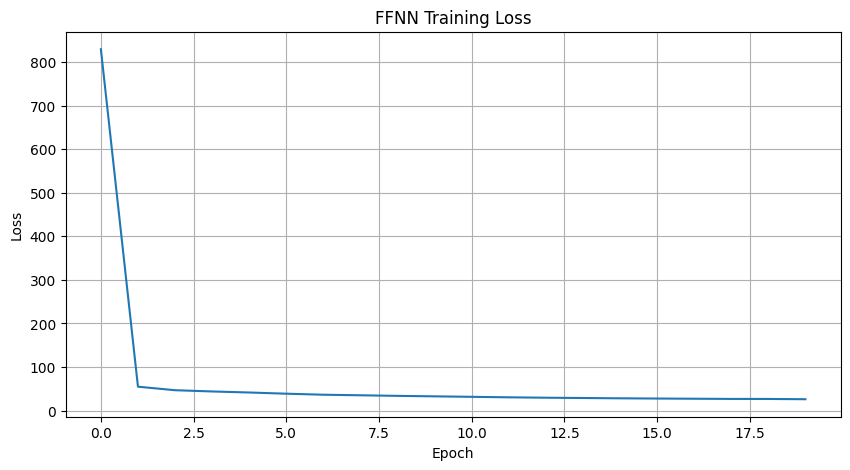

Episode 37/100: Evaluating FFNN
Episode 37/100 | Reward: -1384.6670
Train MSE: 26.1225 | Train Female MSE: 5.9860
Val MSE: 145.6474 | Val Female MSE: 75.1739
Test MSE: 57.6934 | Test Female MSE: 22.1981

--------------------------------

Episode 38/100: Generating Synthetic Data
Episode 38/100: Training FFNN


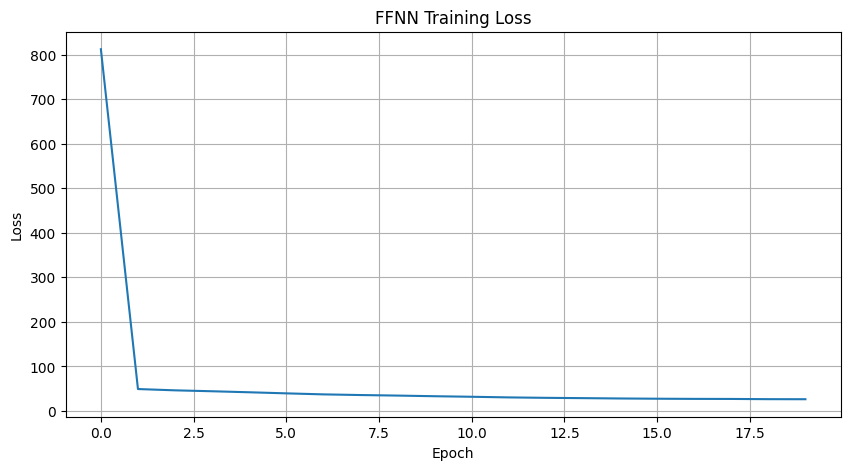

Episode 38/100: Evaluating FFNN
Episode 38/100 | Reward: -1620.0493
Train MSE: 25.8298 | Train Female MSE: 5.4330
Val MSE: 169.3566 | Val Female MSE: 29.0398
Test MSE: 63.0037 | Test Female MSE: 14.6557

--------------------------------

Episode 39/100: Generating Synthetic Data
Episode 39/100: Training FFNN


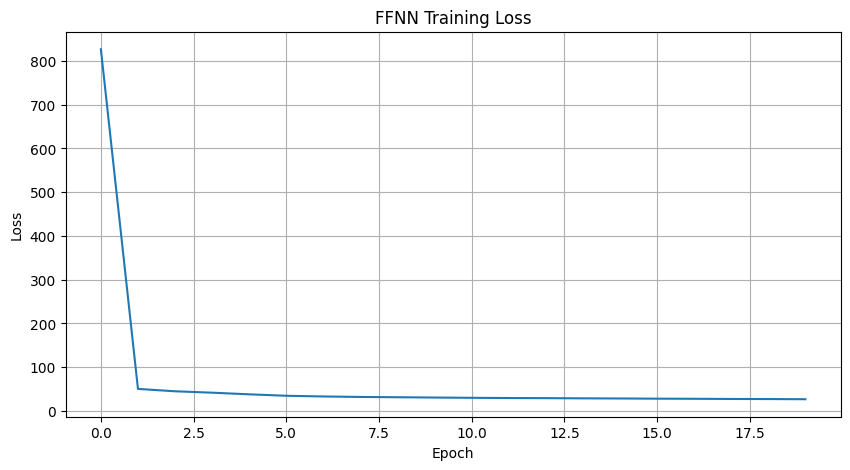

Episode 39/100: Evaluating FFNN
Episode 39/100 | Reward: -1750.1464
Train MSE: 26.3747 | Train Female MSE: 7.7646
Val MSE: 182.1269 | Val Female MSE: 211.7234
Test MSE: 61.6286 | Test Female MSE: 14.8896

--------------------------------

Episode 40/100: Generating Synthetic Data
Episode 40/100: Training FFNN


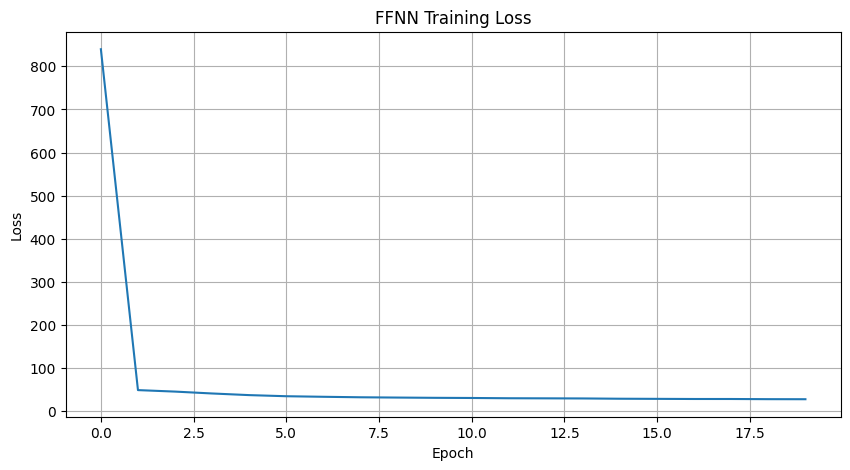

Episode 40/100: Evaluating FFNN
Episode 40/100 | Reward: -1942.5591
Train MSE: 27.3872 | Train Female MSE: 5.7747
Val MSE: 200.7068 | Val Female MSE: 71.3708
Test MSE: 56.8896 | Test Female MSE: 3.8937

--------------------------------

Episode 41/100: Generating Synthetic Data
Episode 41/100: Training FFNN


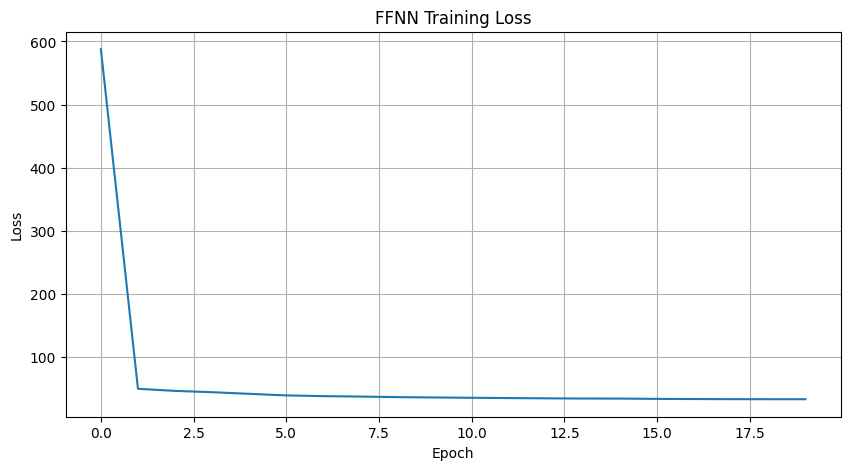

Episode 41/100: Evaluating FFNN
Episode 41/100 | Reward: -1399.4616
Train MSE: 32.3249 | Train Female MSE: 5.9382
Val MSE: 146.2553 | Val Female MSE: 39.0973
Test MSE: 58.9817 | Test Female MSE: 8.1602

--------------------------------

Episode 42/100: Generating Synthetic Data
Episode 42/100: Training FFNN


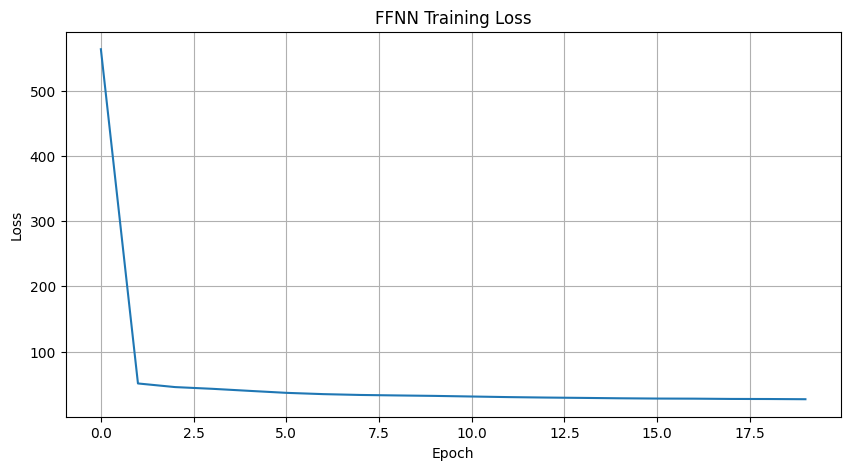

Episode 42/100: Evaluating FFNN
Episode 42/100 | Reward: -1397.3099
Train MSE: 26.5565 | Train Female MSE: 7.7291
Val MSE: 146.0610 | Val Female MSE: 29.6905
Test MSE: 46.8359 | Test Female MSE: 11.2274

--------------------------------

Episode 43/100: Generating Synthetic Data
Episode 43/100: Training FFNN


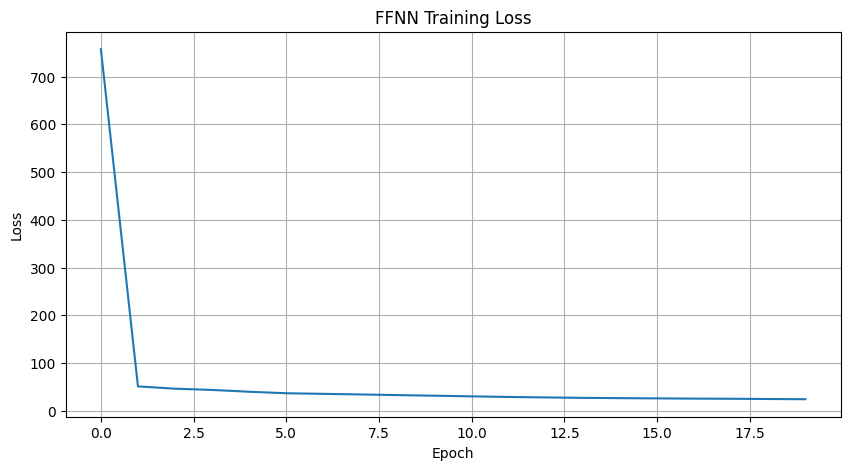

Episode 43/100: Evaluating FFNN
Episode 43/100 | Reward: -543.6433
Train MSE: 23.8380 | Train Female MSE: 5.6900
Val MSE: 61.0487 | Val Female MSE: 6.1259
Test MSE: 45.3914 | Test Female MSE: 4.7257

--------------------------------

Episode 44/100: Generating Synthetic Data
Episode 44/100: Training FFNN


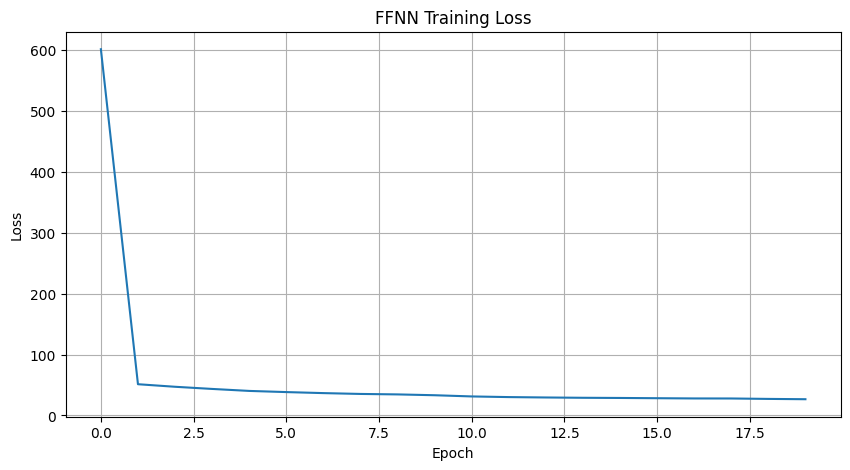

Episode 44/100: Evaluating FFNN
Episode 44/100 | Reward: -1129.2184
Train MSE: 26.0934 | Train Female MSE: 6.0367
Val MSE: 119.6208 | Val Female MSE: 160.1946
Test MSE: 74.9242 | Test Female MSE: 8.6954

--------------------------------

Episode 45/100: Generating Synthetic Data
Episode 45/100: Training FFNN


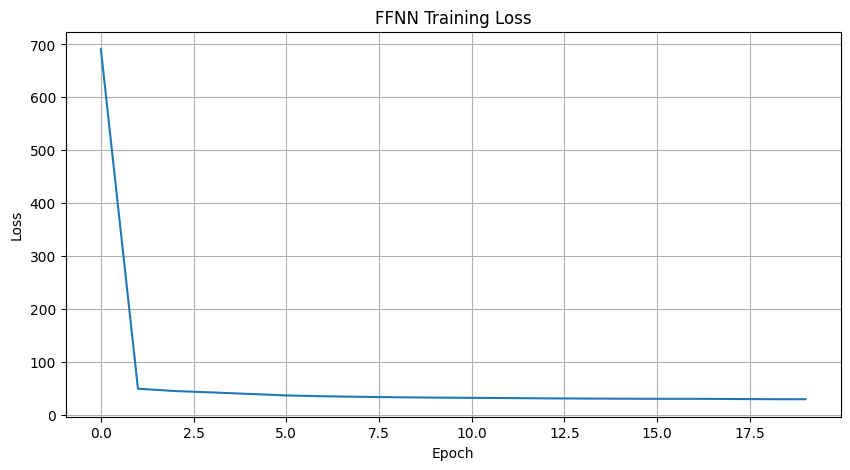

Episode 45/100: Evaluating FFNN
Episode 45/100 | Reward: -1333.1336
Train MSE: 29.2129 | Train Female MSE: 6.7206
Val MSE: 140.3292 | Val Female MSE: 42.4163
Test MSE: 58.0673 | Test Female MSE: 20.3828

--------------------------------

Episode 46/100: Generating Synthetic Data
Episode 46/100: Training FFNN


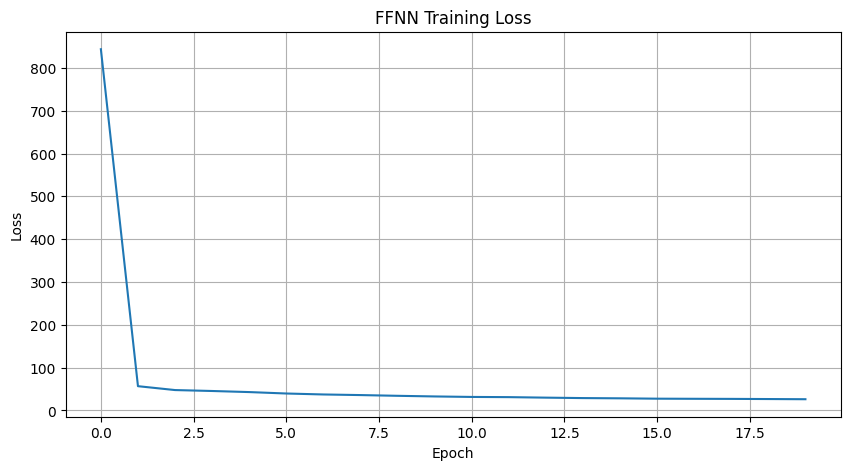

Episode 46/100: Evaluating FFNN
Episode 46/100 | Reward: -1449.2244
Train MSE: 26.1168 | Train Female MSE: 4.9869
Val MSE: 152.0638 | Val Female MSE: 20.7364
Test MSE: 68.8796 | Test Female MSE: 8.4954

--------------------------------

Episode 47/100: Generating Synthetic Data
Episode 47/100: Training FFNN


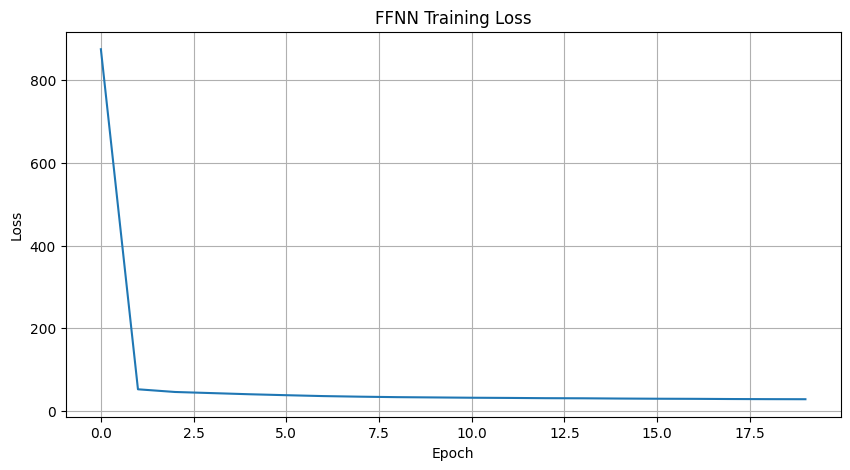

Episode 47/100: Evaluating FFNN
Episode 47/100 | Reward: -872.9589
Train MSE: 28.4170 | Train Female MSE: 6.3463
Val MSE: 94.5343 | Val Female MSE: 32.8054
Test MSE: 51.3901 | Test Female MSE: 8.9223

--------------------------------

Episode 48/100: Generating Synthetic Data
Episode 48/100: Training FFNN


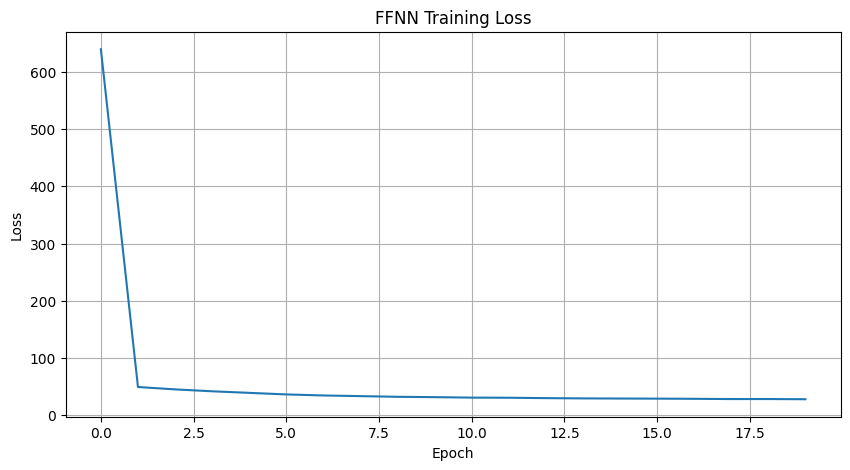

Episode 48/100: Evaluating FFNN
Episode 48/100 | Reward: -1973.9718
Train MSE: 29.9505 | Train Female MSE: 9.1849
Val MSE: 204.8690 | Val Female MSE: 42.2348
Test MSE: 41.1731 | Test Female MSE: 21.7325

--------------------------------

Episode 49/100: Generating Synthetic Data
Episode 49/100: Training FFNN


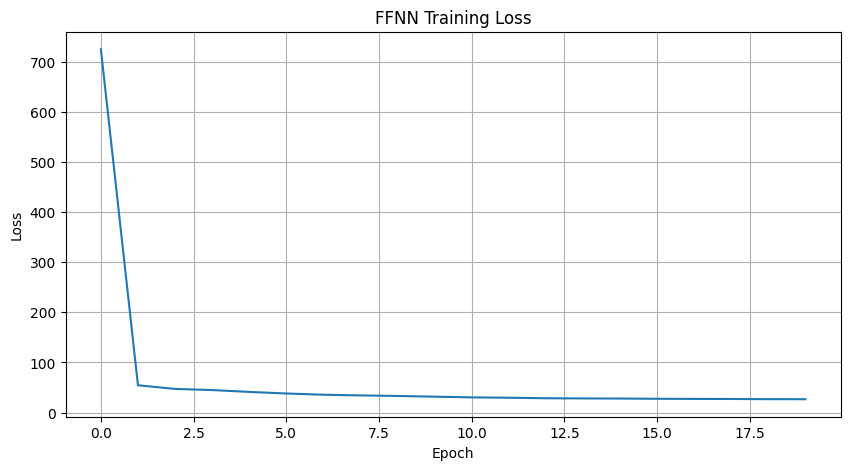

Episode 49/100: Evaluating FFNN
Episode 49/100 | Reward: -1031.2106
Train MSE: 29.3686 | Train Female MSE: 9.4409
Val MSE: 110.1412 | Val Female MSE: 19.5078
Test MSE: 43.5966 | Test Female MSE: 5.1636

--------------------------------

Episode 50/100: Generating Synthetic Data
Episode 50/100: Training FFNN


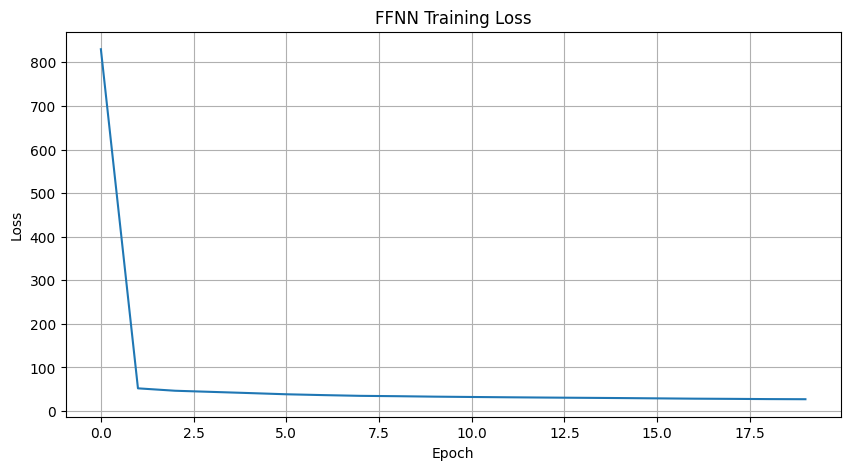

Episode 50/100: Evaluating FFNN
Episode 50/100 | Reward: -1007.6836
Train MSE: 27.0542 | Train Female MSE: 6.6935
Val MSE: 108.2098 | Val Female MSE: 58.0896
Test MSE: 49.8223 | Test Female MSE: 5.4544

--------------------------------

Episode 51/100: Generating Synthetic Data
Episode 51/100: Training FFNN


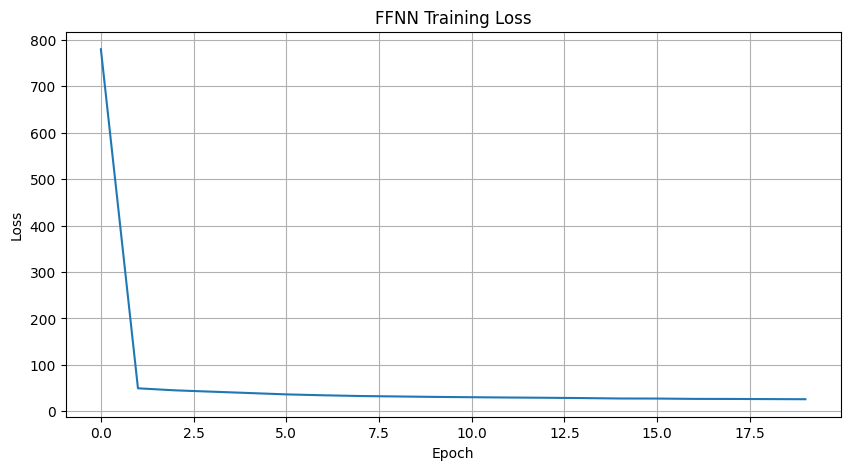

Episode 51/100: Evaluating FFNN
Episode 51/100 | Reward: -1039.2096
Train MSE: 25.8630 | Train Female MSE: 6.5302
Val MSE: 112.2916 | Val Female MSE: 6.7010
Test MSE: 53.8138 | Test Female MSE: 5.4191

--------------------------------

Episode 52/100: Generating Synthetic Data
Episode 52/100: Training FFNN


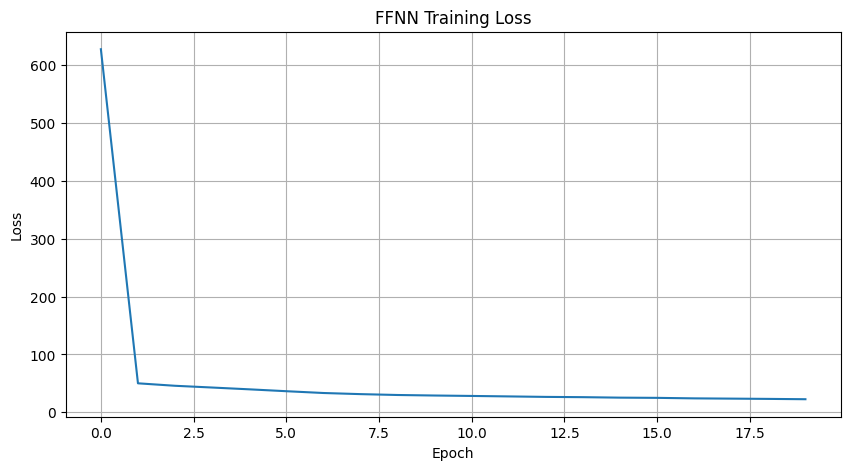

Episode 52/100: Evaluating FFNN
Episode 52/100 | Reward: -872.6857
Train MSE: 22.1781 | Train Female MSE: 3.5273
Val MSE: 93.8302 | Val Female MSE: 38.8809
Test MSE: 62.2690 | Test Female MSE: 2.2521

--------------------------------

Episode 53/100: Generating Synthetic Data
Episode 53/100: Training FFNN


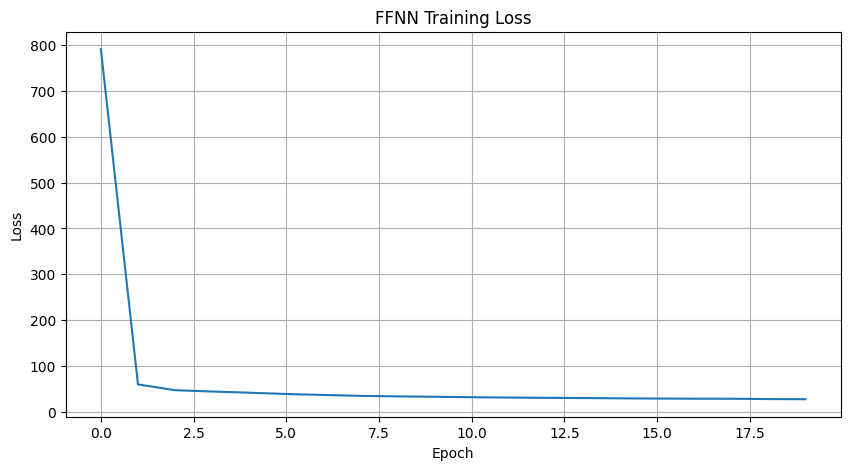

Episode 53/100: Evaluating FFNN
Episode 53/100 | Reward: -2070.3237
Train MSE: 27.1761 | Train Female MSE: 6.8330
Val MSE: 212.9205 | Val Female MSE: 154.3106
Test MSE: 68.1077 | Test Female MSE: 47.4874

--------------------------------

Episode 54/100: Generating Synthetic Data
Episode 54/100: Training FFNN


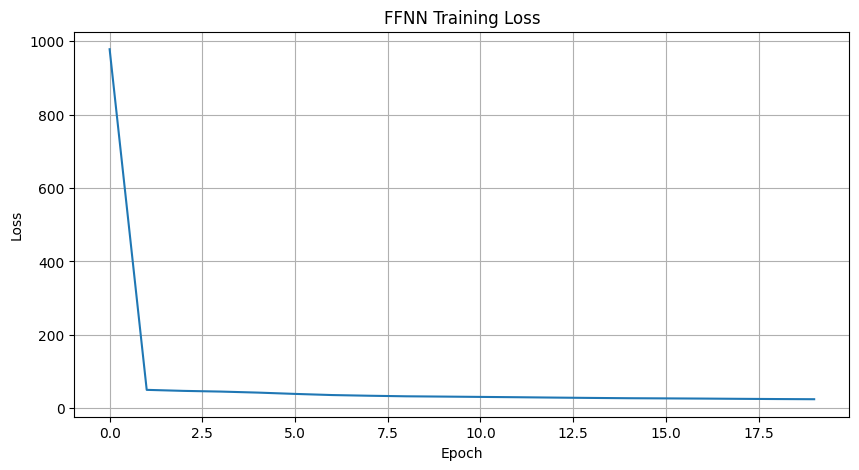

Episode 54/100: Evaluating FFNN
Episode 54/100 | Reward: -3394.1527
Train MSE: 24.9049 | Train Female MSE: 7.2160
Val MSE: 344.6904 | Val Female MSE: 155.8846
Test MSE: 75.6243 | Test Female MSE: 29.6196

--------------------------------

Episode 55/100: Generating Synthetic Data
Episode 55/100: Training FFNN


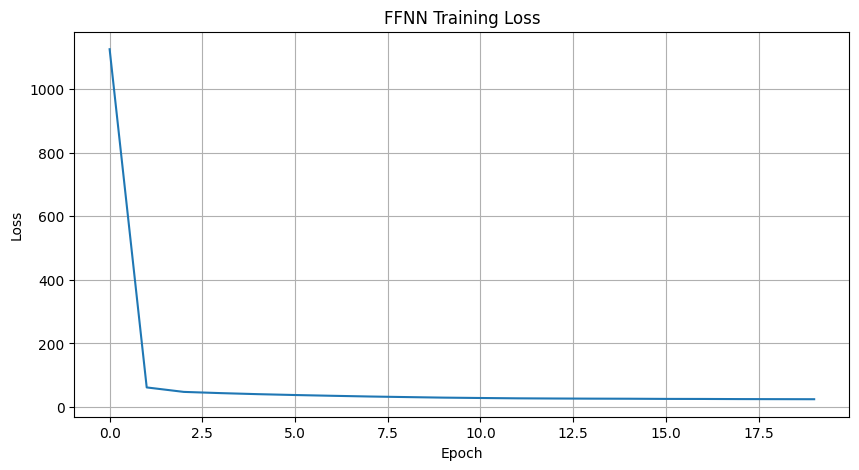

Episode 55/100: Evaluating FFNN
Episode 55/100 | Reward: -964.0227
Train MSE: 24.2128 | Train Female MSE: 3.9453
Val MSE: 102.0073 | Val Female MSE: 16.5020
Test MSE: 54.5355 | Test Female MSE: 5.8630

--------------------------------

Episode 56/100: Generating Synthetic Data
Episode 56/100: Training FFNN


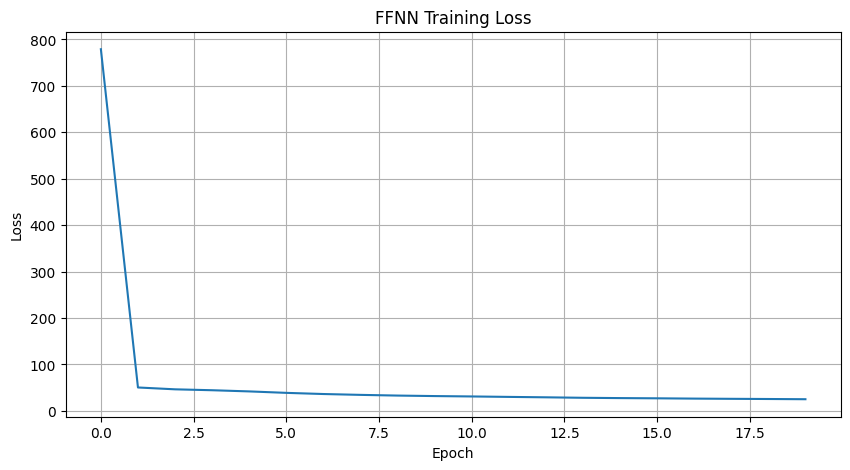

Episode 56/100: Evaluating FFNN
Episode 56/100 | Reward: -1043.1839
Train MSE: 25.3456 | Train Female MSE: 7.4377
Val MSE: 110.1647 | Val Female MSE: 31.2727
Test MSE: 53.8657 | Test Female MSE: 4.7510

--------------------------------

Episode 57/100: Generating Synthetic Data
Episode 57/100: Training FFNN


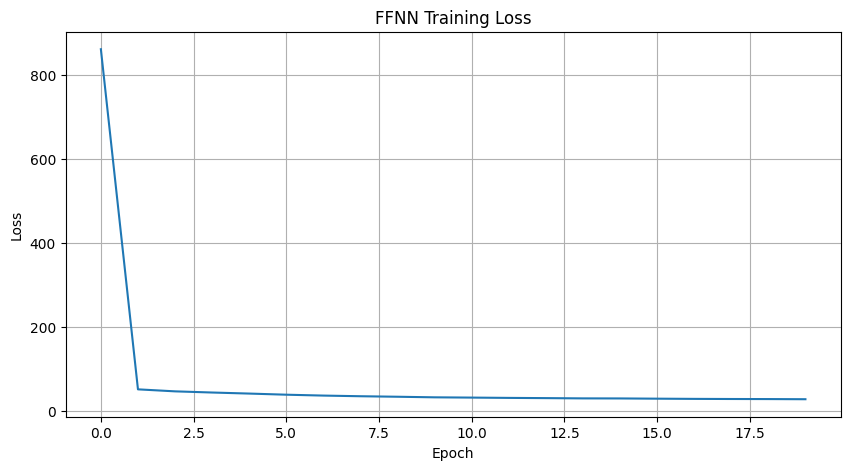

Episode 57/100: Evaluating FFNN
Episode 57/100 | Reward: -1409.5171
Train MSE: 26.8178 | Train Female MSE: 6.5028
Val MSE: 146.1145 | Val Female MSE: 26.9819
Test MSE: 52.2838 | Test Female MSE: 19.9420

--------------------------------

Episode 58/100: Generating Synthetic Data
Episode 58/100: Training FFNN


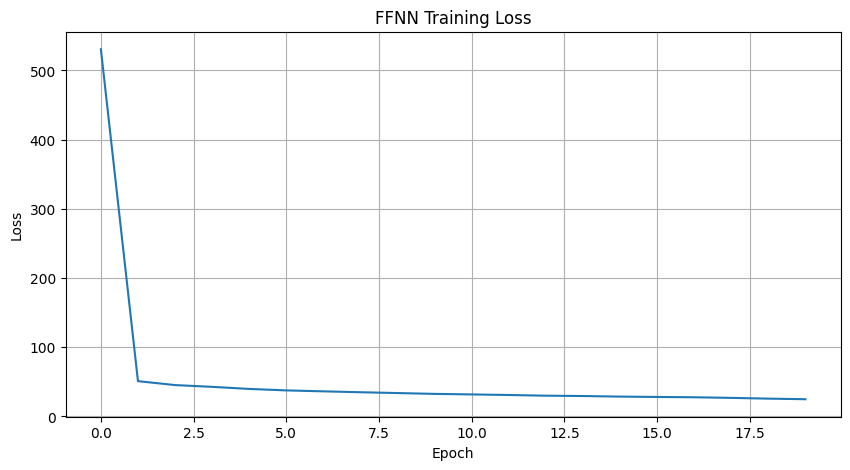

Episode 58/100: Evaluating FFNN
Episode 58/100 | Reward: -671.9828
Train MSE: 23.9027 | Train Female MSE: 5.1755
Val MSE: 72.0907 | Val Female MSE: 14.8886
Test MSE: 45.9148 | Test Female MSE: 5.2833

--------------------------------

Episode 59/100: Generating Synthetic Data
Episode 59/100: Training FFNN


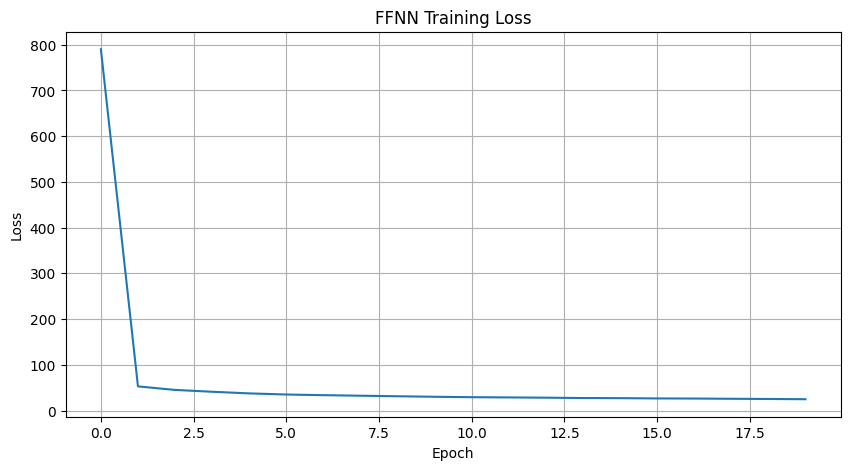

Episode 59/100: Evaluating FFNN
Episode 59/100 | Reward: -613.6582
Train MSE: 24.9463 | Train Female MSE: 6.2988
Val MSE: 66.3798 | Val Female MSE: 42.9431
Test MSE: 62.3621 | Test Female MSE: 5.7558

--------------------------------

Episode 60/100: Generating Synthetic Data
Episode 60/100: Training FFNN


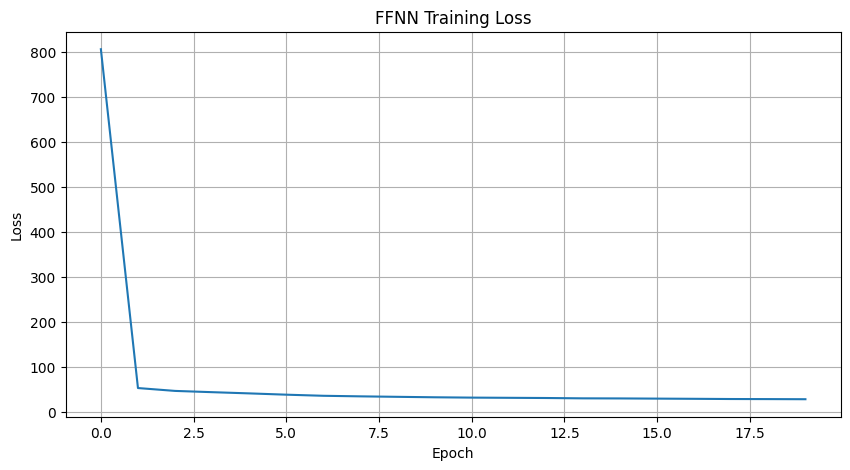

Episode 60/100: Evaluating FFNN
Episode 60/100 | Reward: -800.1449
Train MSE: 27.8874 | Train Female MSE: 7.4413
Val MSE: 85.1543 | Val Female MSE: 13.7275
Test MSE: 55.2130 | Test Female MSE: 11.9665

--------------------------------

Episode 61/100: Generating Synthetic Data
Episode 61/100: Training FFNN


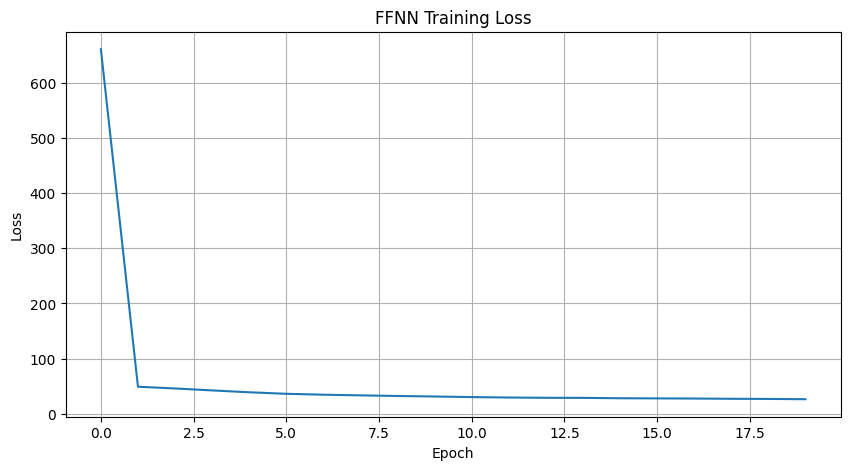

Episode 61/100: Evaluating FFNN
Episode 61/100 | Reward: -1627.8150
Train MSE: 28.4753 | Train Female MSE: 6.7941
Val MSE: 168.0905 | Val Female MSE: 36.0551
Test MSE: 63.7821 | Test Female MSE: 7.0999

--------------------------------

Episode 62/100: Generating Synthetic Data
Episode 62/100: Training FFNN


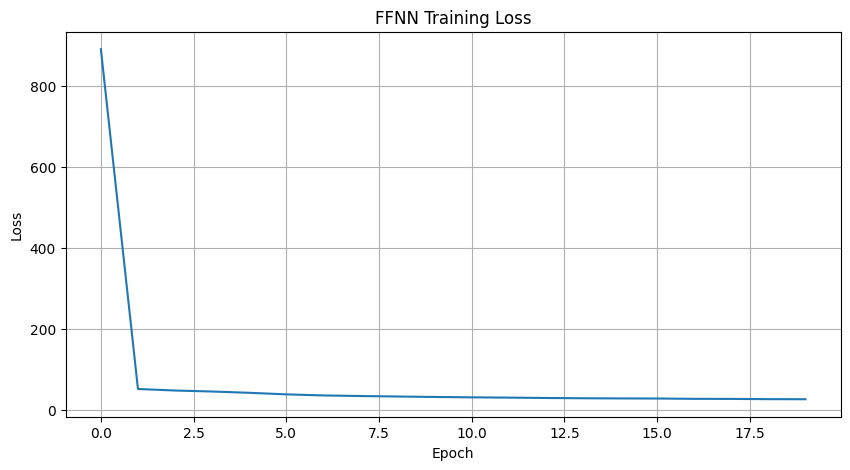

Episode 62/100: Evaluating FFNN
Episode 62/100 | Reward: -2033.3074
Train MSE: 25.0402 | Train Female MSE: 5.8602
Val MSE: 209.8873 | Val Female MSE: 70.3785
Test MSE: 56.4512 | Test Female MSE: 23.4564

--------------------------------

Episode 63/100: Generating Synthetic Data
Episode 63/100: Training FFNN


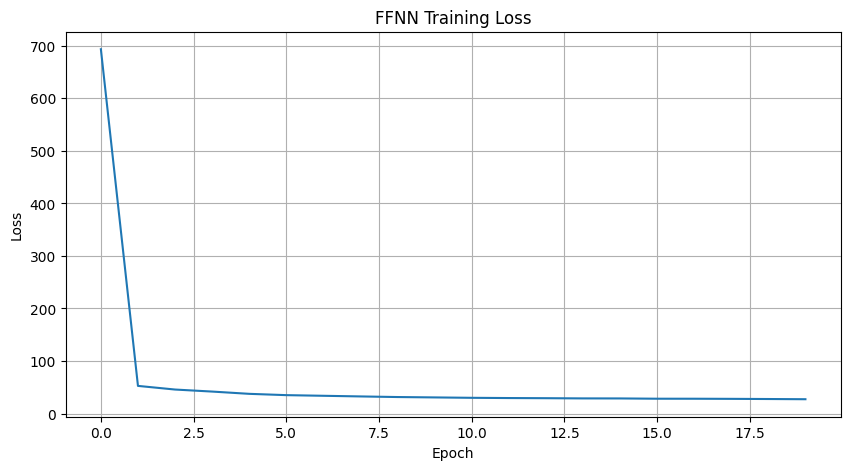

Episode 63/100: Evaluating FFNN
Episode 63/100 | Reward: -841.2895
Train MSE: 26.8185 | Train Female MSE: 5.5668
Val MSE: 90.6018 | Val Female MSE: 32.8792
Test MSE: 113.5716 | Test Female MSE: 45.2190

--------------------------------

Episode 64/100: Generating Synthetic Data
Episode 64/100: Training FFNN


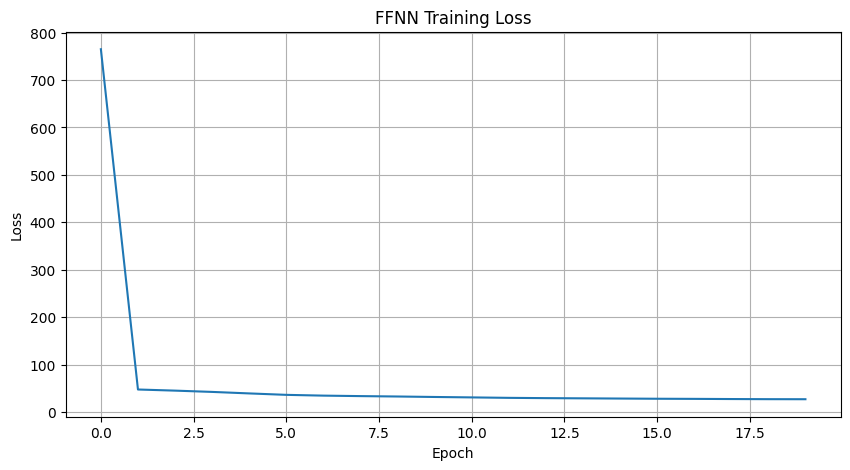

Episode 64/100: Evaluating FFNN
Episode 64/100 | Reward: -1340.7344
Train MSE: 26.9855 | Train Female MSE: 7.0273
Val MSE: 140.3236 | Val Female MSE: 73.7283
Test MSE: 56.4923 | Test Female MSE: 10.0683

--------------------------------

Episode 65/100: Generating Synthetic Data
Episode 65/100: Training FFNN


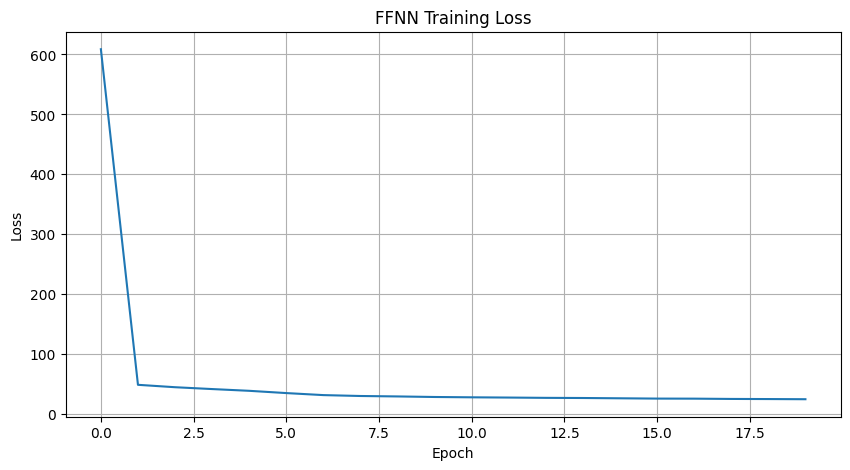

Episode 65/100: Evaluating FFNN
Episode 65/100 | Reward: -908.6968
Train MSE: 24.6650 | Train Female MSE: 7.7875
Val MSE: 97.2169 | Val Female MSE: 20.6933
Test MSE: 49.2352 | Test Female MSE: 6.2939

--------------------------------

Episode 66/100: Generating Synthetic Data
Episode 66/100: Training FFNN


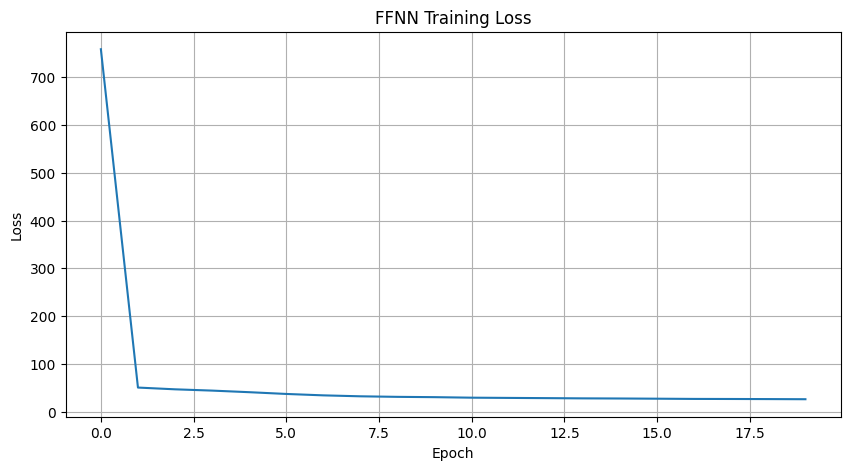

Episode 66/100: Evaluating FFNN
Episode 66/100 | Reward: -800.4969
Train MSE: 25.9885 | Train Female MSE: 8.1019
Val MSE: 86.9065 | Val Female MSE: 50.2187
Test MSE: 55.1176 | Test Female MSE: 5.9325

--------------------------------

Episode 67/100: Generating Synthetic Data
Episode 67/100: Training FFNN


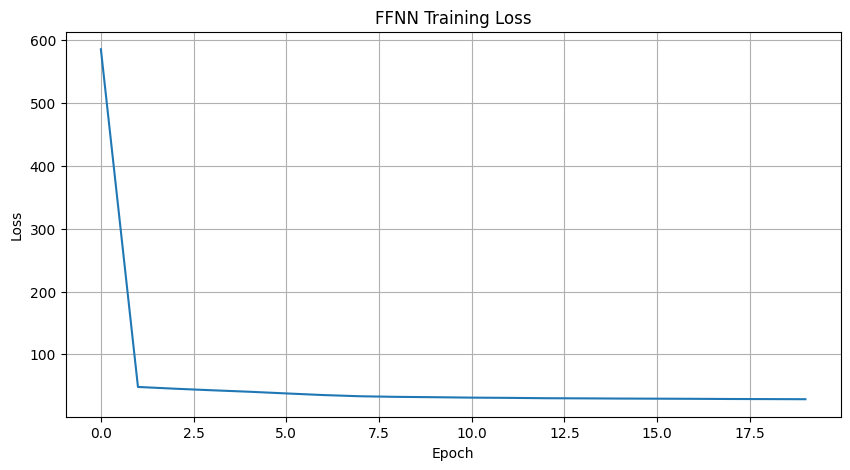

Episode 67/100: Evaluating FFNN
Episode 67/100 | Reward: -918.7001
Train MSE: 27.7914 | Train Female MSE: 6.3858
Val MSE: 99.1046 | Val Female MSE: 27.1653
Test MSE: 64.2089 | Test Female MSE: 19.6585

--------------------------------

Episode 68/100: Generating Synthetic Data
Episode 68/100: Training FFNN


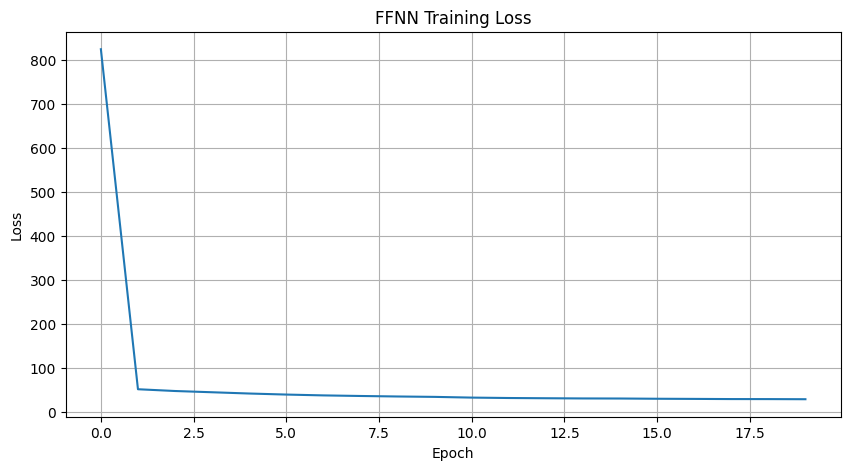

Episode 68/100: Evaluating FFNN
Episode 68/100 | Reward: -2766.8413
Train MSE: 27.5557 | Train Female MSE: 5.5369
Val MSE: 283.4728 | Val Female MSE: 32.3728
Test MSE: 61.3860 | Test Female MSE: 8.0665

--------------------------------

Episode 69/100: Generating Synthetic Data
Episode 69/100: Training FFNN


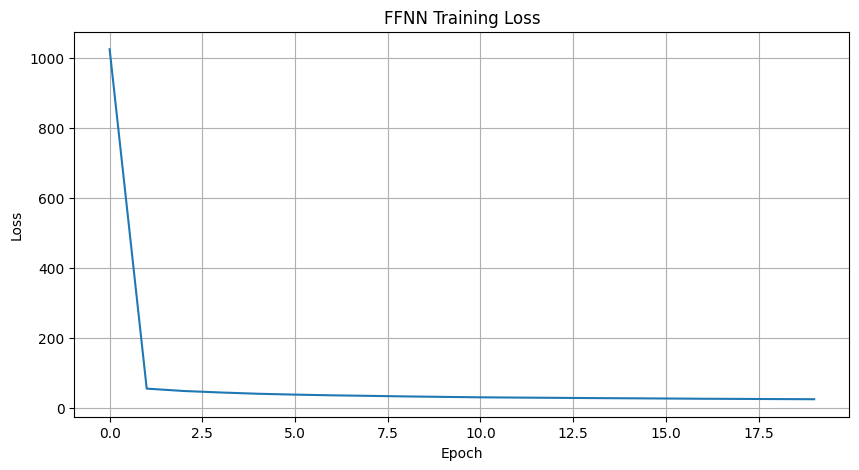

Episode 69/100: Evaluating FFNN
Episode 69/100 | Reward: -865.4017
Train MSE: 24.2068 | Train Female MSE: 4.1952
Val MSE: 93.2478 | Val Female MSE: 10.9957
Test MSE: 61.6336 | Test Female MSE: 1.3108

--------------------------------

Episode 70/100: Generating Synthetic Data
Episode 70/100: Training FFNN


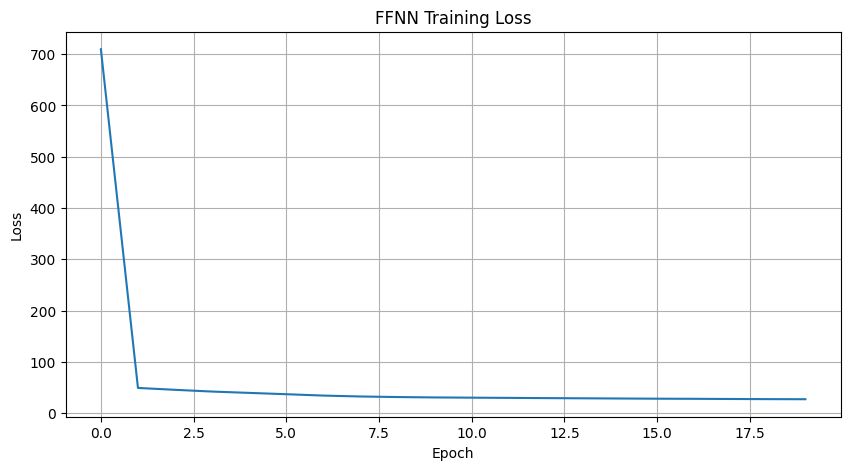

Episode 70/100: Evaluating FFNN
Episode 70/100 | Reward: -1168.6521
Train MSE: 31.2925 | Train Female MSE: 11.9568
Val MSE: 123.5842 | Val Female MSE: 61.7694
Test MSE: 57.8645 | Test Female MSE: 16.3094

--------------------------------

Episode 71/100: Generating Synthetic Data
Episode 71/100: Training FFNN


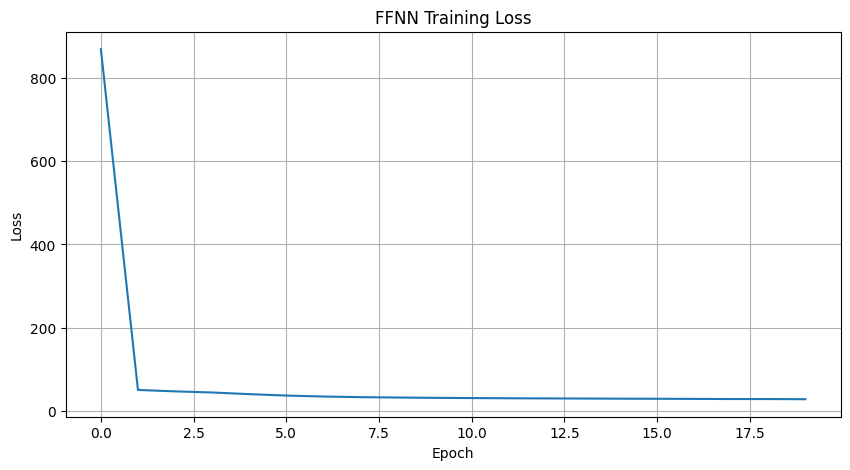

Episode 71/100: Evaluating FFNN
Episode 71/100 | Reward: -1419.8497
Train MSE: 34.8563 | Train Female MSE: 13.5941
Val MSE: 148.9104 | Val Female MSE: 38.9818
Test MSE: 40.5905 | Test Female MSE: 7.4873

--------------------------------

Episode 72/100: Generating Synthetic Data
Episode 72/100: Training FFNN


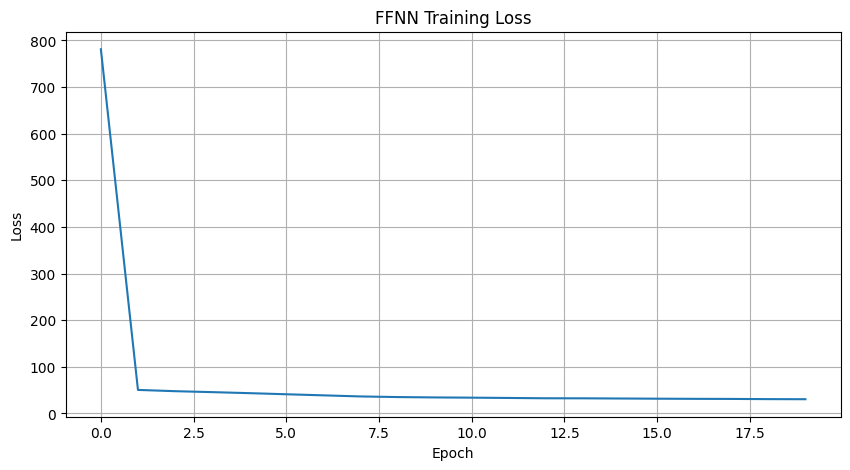

Episode 72/100: Evaluating FFNN
Episode 72/100 | Reward: -1902.6772
Train MSE: 30.3287 | Train Female MSE: 6.8418
Val MSE: 197.3620 | Val Female MSE: 58.5242
Test MSE: 56.3886 | Test Female MSE: 5.7245

--------------------------------

Episode 73/100: Generating Synthetic Data
Episode 73/100: Training FFNN


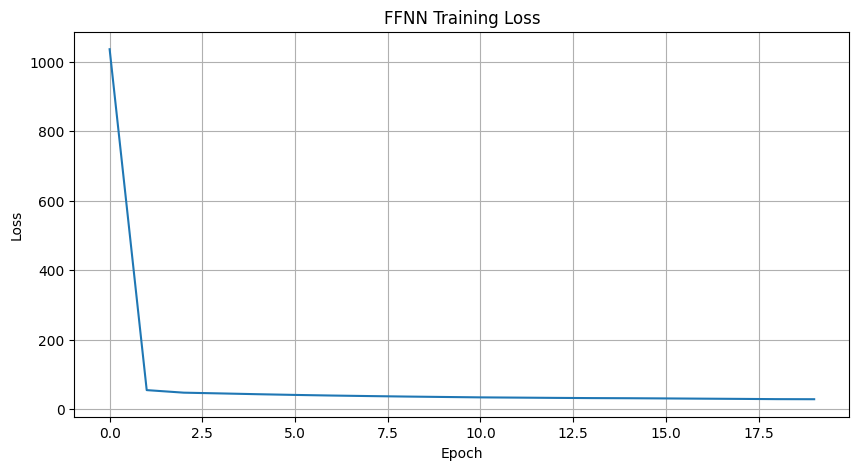

Episode 73/100: Evaluating FFNN
Episode 73/100 | Reward: -1157.9078
Train MSE: 31.3056 | Train Female MSE: 8.2358
Val MSE: 122.7636 | Val Female MSE: 93.4365
Test MSE: 70.3244 | Test Female MSE: 15.3217

--------------------------------

Episode 74/100: Generating Synthetic Data
Episode 74/100: Training FFNN


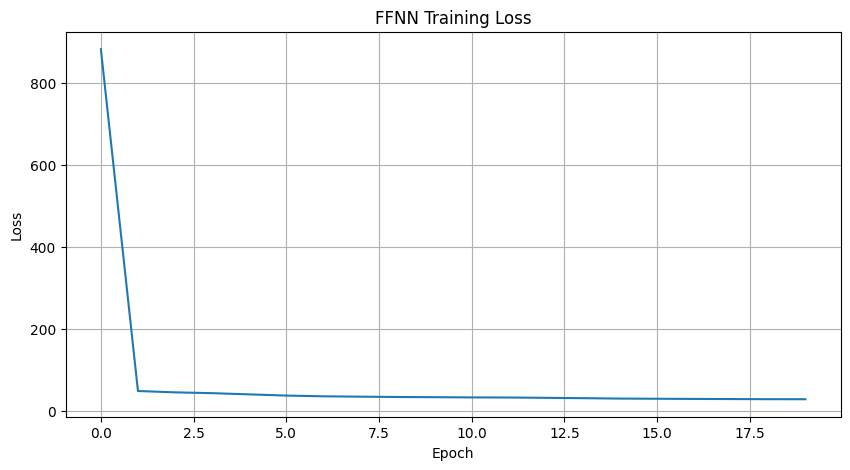

Episode 74/100: Evaluating FFNN
Episode 74/100 | Reward: -1700.4980
Train MSE: 29.7784 | Train Female MSE: 9.2230
Val MSE: 176.6698 | Val Female MSE: 33.8956
Test MSE: 61.3207 | Test Female MSE: 30.8871

--------------------------------

Episode 75/100: Generating Synthetic Data
Episode 75/100: Training FFNN


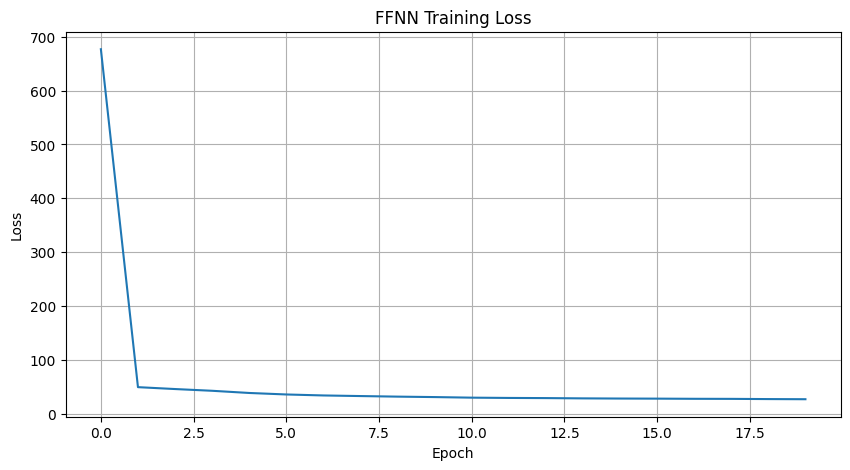

Episode 75/100: Evaluating FFNN
Episode 75/100 | Reward: -634.7268
Train MSE: 26.6690 | Train Female MSE: 6.3934
Val MSE: 70.0343 | Val Female MSE: 54.9320
Test MSE: 59.1410 | Test Female MSE: 15.2681

--------------------------------

Episode 76/100: Generating Synthetic Data
Episode 76/100: Training FFNN


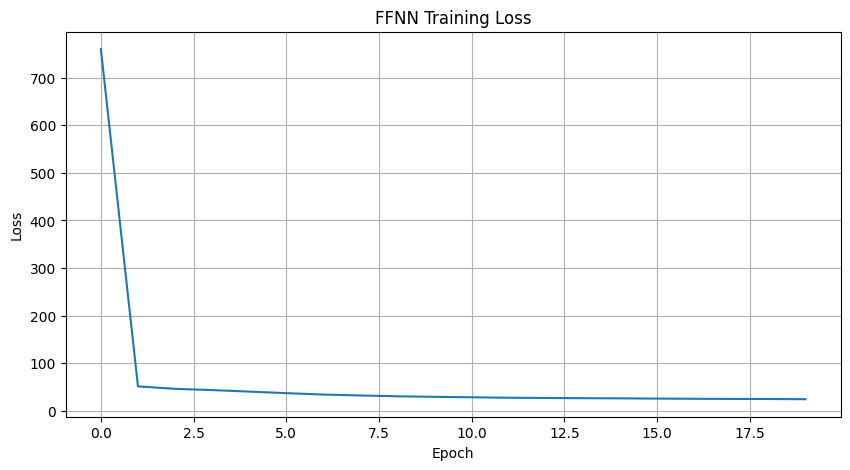

Episode 76/100: Evaluating FFNN
Episode 76/100 | Reward: -1975.1747
Train MSE: 24.0660 | Train Female MSE: 5.7462
Val MSE: 204.9876 | Val Female MSE: 142.7303
Test MSE: 91.0074 | Test Female MSE: 14.9329

--------------------------------

Episode 77/100: Generating Synthetic Data
Episode 77/100: Training FFNN


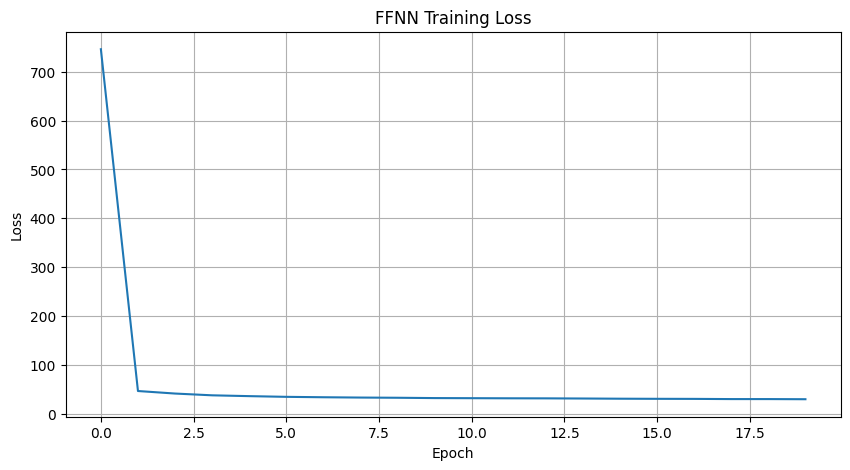

Episode 77/100: Evaluating FFNN
Episode 77/100 | Reward: -2620.6937
Train MSE: 28.6882 | Train Female MSE: 6.9163
Val MSE: 268.0517 | Val Female MSE: 49.0759
Test MSE: 65.6500 | Test Female MSE: 13.9167

--------------------------------

Episode 78/100: Generating Synthetic Data
Episode 78/100: Training FFNN


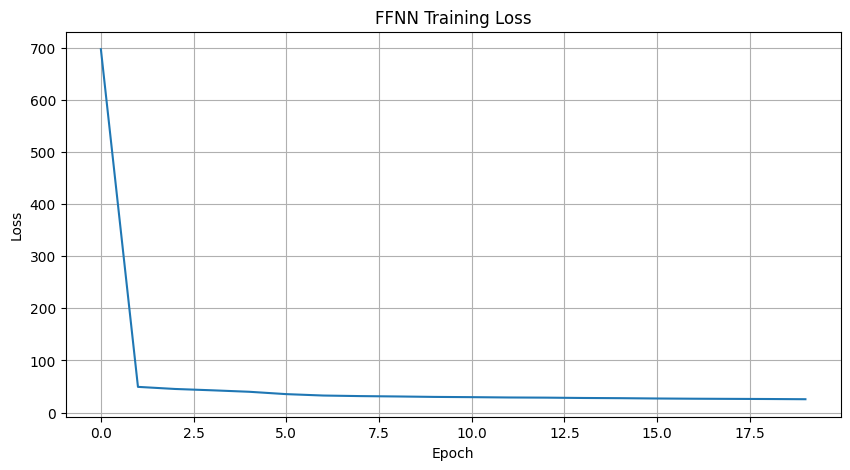

Episode 78/100: Evaluating FFNN
Episode 78/100 | Reward: -1381.9169
Train MSE: 26.2141 | Train Female MSE: 6.4859
Val MSE: 144.2318 | Val Female MSE: 8.4187
Test MSE: 65.5783 | Test Female MSE: 9.5909

--------------------------------

Episode 79/100: Generating Synthetic Data
Episode 79/100: Training FFNN


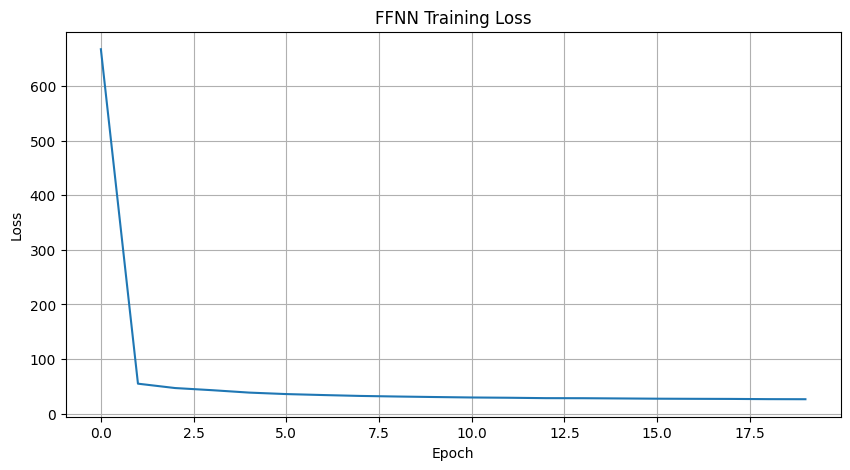

Episode 79/100: Evaluating FFNN
Episode 79/100 | Reward: -735.4710
Train MSE: 26.7424 | Train Female MSE: 6.4138
Val MSE: 79.8825 | Val Female MSE: 7.6009
Test MSE: 50.5095 | Test Female MSE: 9.3595

--------------------------------

Episode 80/100: Generating Synthetic Data
Episode 80/100: Training FFNN


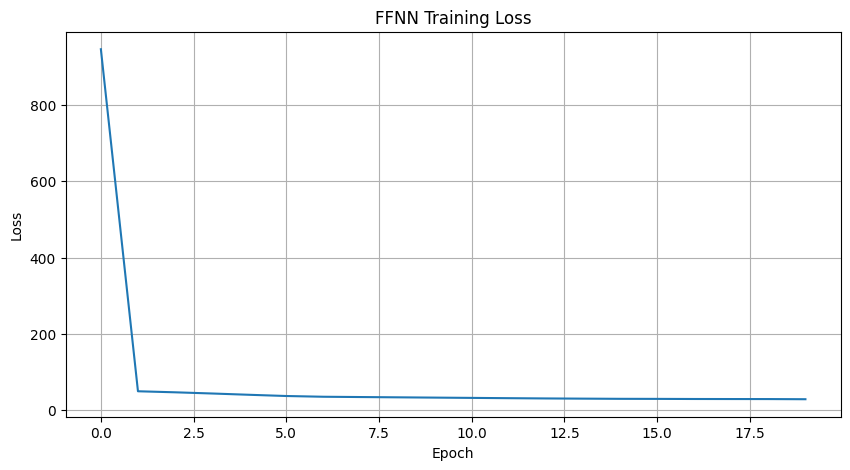

Episode 80/100: Evaluating FFNN
Episode 80/100 | Reward: -1255.5278
Train MSE: 27.9160 | Train Female MSE: 6.3556
Val MSE: 131.9388 | Val Female MSE: 51.9897
Test MSE: 42.7806 | Test Female MSE: 4.3021

--------------------------------

Episode 81/100: Generating Synthetic Data
Episode 81/100: Training FFNN


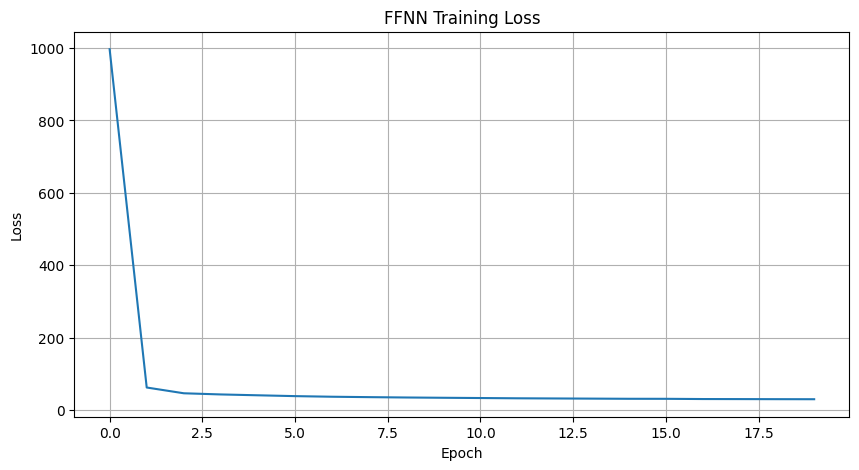

Episode 81/100: Evaluating FFNN
Episode 81/100 | Reward: -2548.9364
Train MSE: 30.1608 | Train Female MSE: 5.2623
Val MSE: 261.7231 | Val Female MSE: 105.4106
Test MSE: 101.4163 | Test Female MSE: 24.7712

--------------------------------

Episode 82/100: Generating Synthetic Data
Episode 82/100: Training FFNN


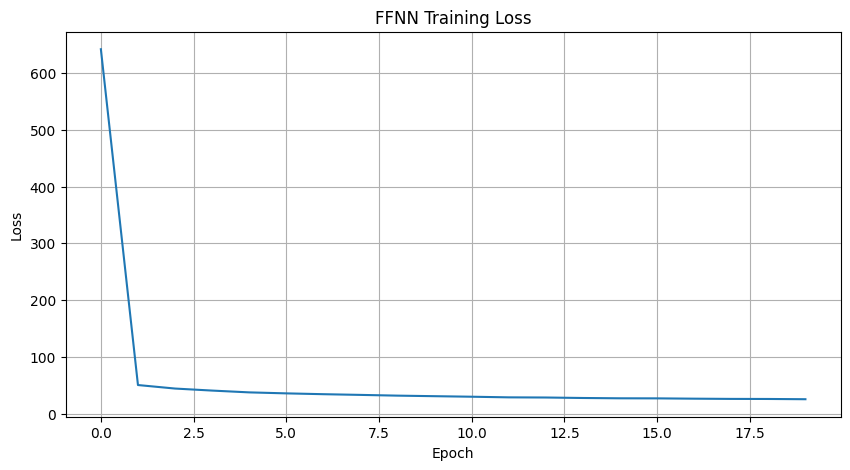

Episode 82/100: Evaluating FFNN
Episode 82/100 | Reward: -694.3816
Train MSE: 24.9293 | Train Female MSE: 4.2791
Val MSE: 77.7547 | Val Female MSE: 25.6678
Test MSE: 52.4837 | Test Female MSE: 1.5826

--------------------------------

Episode 83/100: Generating Synthetic Data
Episode 83/100: Training FFNN


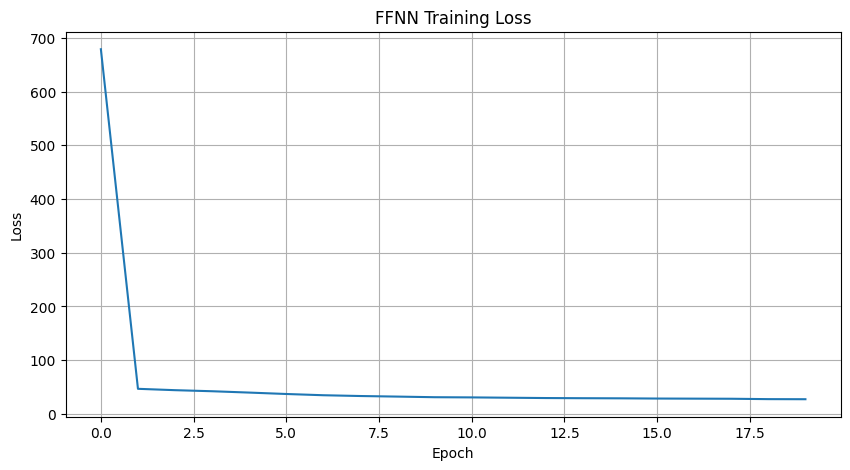

Episode 83/100: Evaluating FFNN
Episode 83/100 | Reward: -761.7086
Train MSE: 27.2709 | Train Female MSE: 7.2668
Val MSE: 83.2988 | Val Female MSE: 35.7580
Test MSE: 48.5606 | Test Female MSE: 12.1295

--------------------------------

Episode 84/100: Generating Synthetic Data
Episode 84/100: Training FFNN


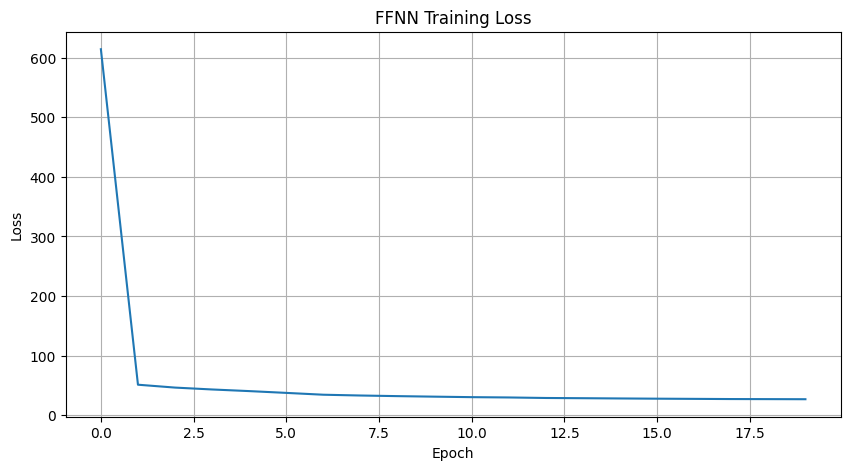

Episode 84/100: Evaluating FFNN
Episode 84/100 | Reward: -1666.2913
Train MSE: 25.8277 | Train Female MSE: 6.4431
Val MSE: 174.3878 | Val Female MSE: 180.7025
Test MSE: 51.9399 | Test Female MSE: 4.3201

--------------------------------

Episode 85/100: Generating Synthetic Data
Episode 85/100: Training FFNN


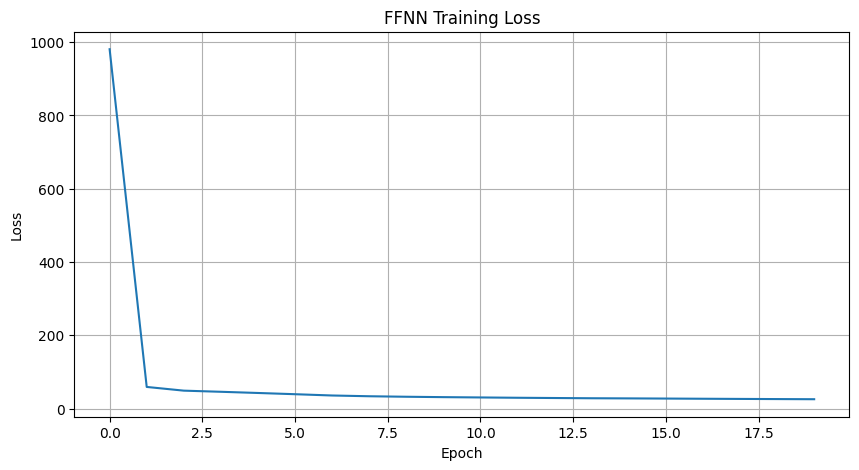

Episode 85/100: Evaluating FFNN
Episode 85/100 | Reward: -552.4817
Train MSE: 25.0282 | Train Female MSE: 5.2230
Val MSE: 63.5515 | Val Female MSE: 13.8335
Test MSE: 75.2128 | Test Female MSE: 2.3363

--------------------------------

Episode 86/100: Generating Synthetic Data
Episode 86/100: Training FFNN


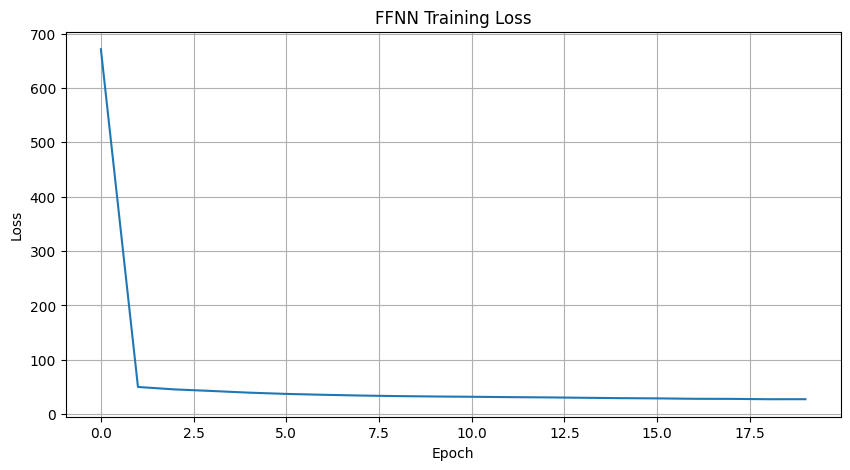

Episode 86/100: Evaluating FFNN
Episode 86/100 | Reward: -716.3368
Train MSE: 28.5308 | Train Female MSE: 7.1815
Val MSE: 79.6095 | Val Female MSE: 23.7678
Test MSE: 42.4532 | Test Female MSE: 12.6210

--------------------------------

Episode 87/100: Generating Synthetic Data
Episode 87/100: Training FFNN


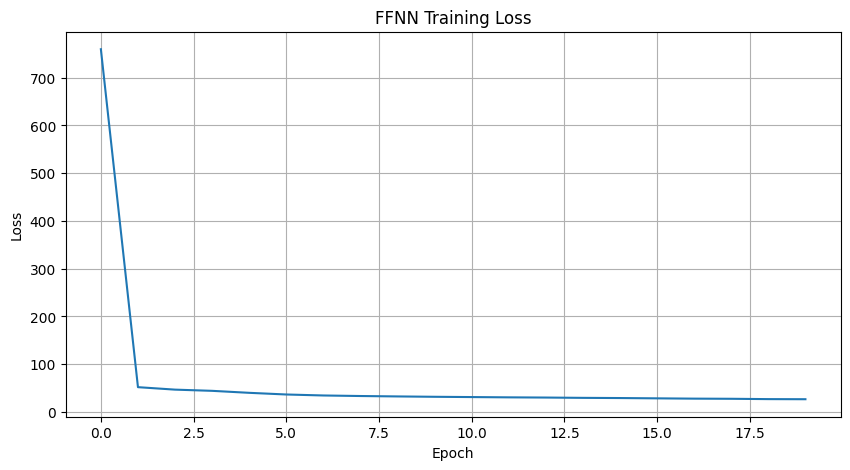

Episode 87/100: Evaluating FFNN
Episode 87/100 | Reward: -1325.5230
Train MSE: 27.0677 | Train Female MSE: 7.8931
Val MSE: 140.3716 | Val Female MSE: 59.0655
Test MSE: 55.4998 | Test Female MSE: 20.3971

--------------------------------

Episode 88/100: Generating Synthetic Data
Episode 88/100: Training FFNN


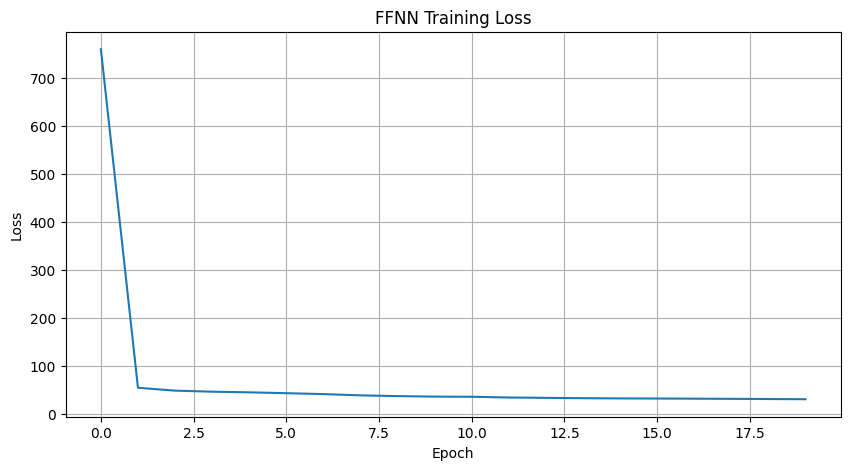

Episode 88/100: Evaluating FFNN
Episode 88/100 | Reward: -823.4726
Train MSE: 30.5461 | Train Female MSE: 8.0970
Val MSE: 91.6439 | Val Female MSE: 12.4620
Test MSE: 47.4816 | Test Female MSE: 4.4332

--------------------------------

Episode 89/100: Generating Synthetic Data
Episode 89/100: Training FFNN


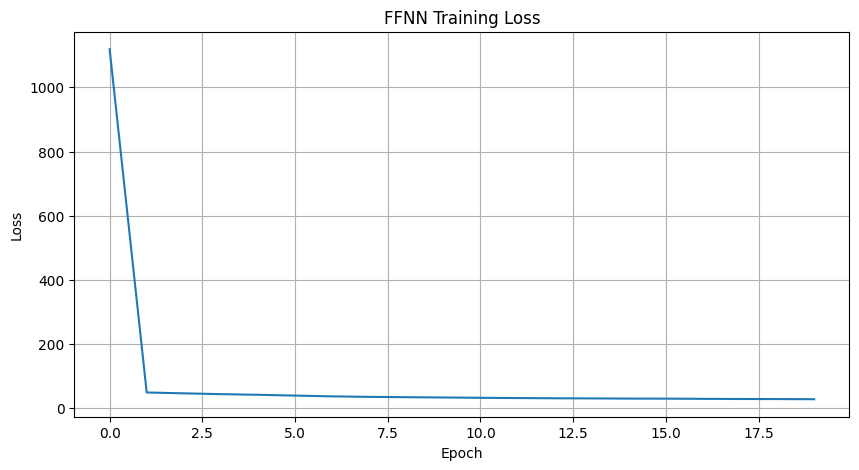

Episode 89/100: Evaluating FFNN
Episode 89/100 | Reward: -1773.4716
Train MSE: 27.2610 | Train Female MSE: 4.4111
Val MSE: 186.2469 | Val Female MSE: 71.5557
Test MSE: 68.1991 | Test Female MSE: 19.5165

--------------------------------

Episode 90/100: Generating Synthetic Data
Episode 90/100: Training FFNN


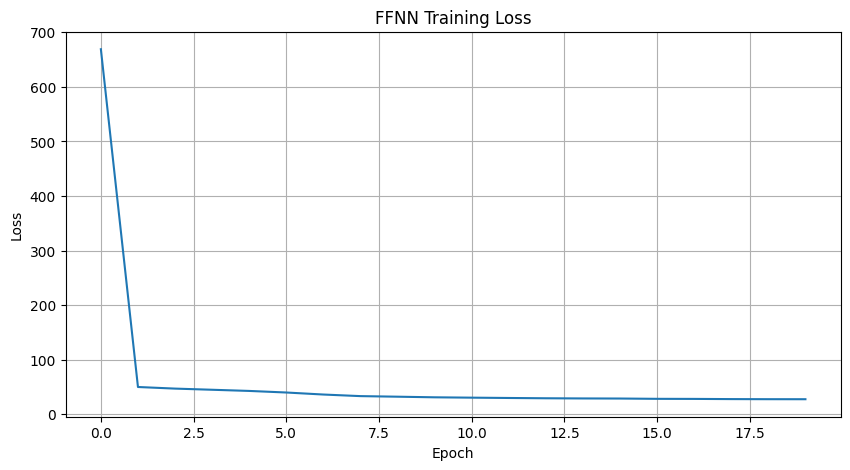

Episode 90/100: Evaluating FFNN
Episode 90/100 | Reward: -1619.6113
Train MSE: 27.4732 | Train Female MSE: 7.1574
Val MSE: 170.2903 | Val Female MSE: 84.2120
Test MSE: 60.6618 | Test Female MSE: 38.8443

--------------------------------

Episode 91/100: Generating Synthetic Data
Episode 91/100: Training FFNN


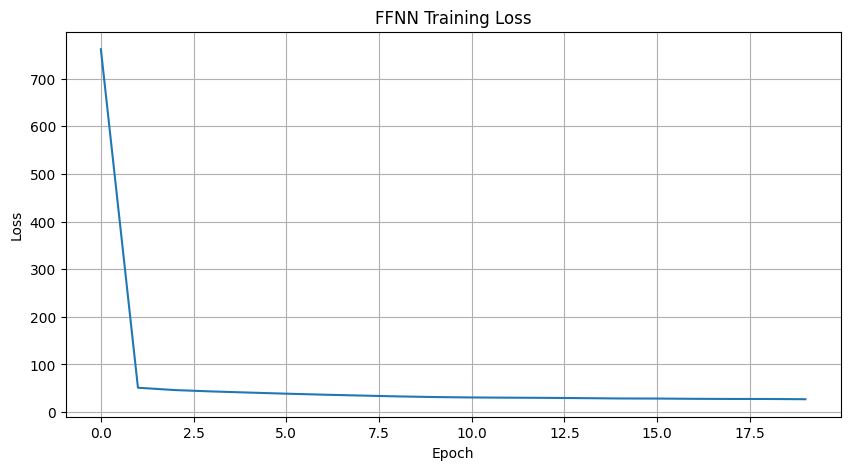

Episode 91/100: Evaluating FFNN
Episode 91/100 | Reward: -575.7124
Train MSE: 28.0510 | Train Female MSE: 6.6460
Val MSE: 65.6745 | Val Female MSE: 11.7391
Test MSE: 116.4571 | Test Female MSE: 36.4496

--------------------------------

Episode 92/100: Generating Synthetic Data
Episode 92/100: Training FFNN


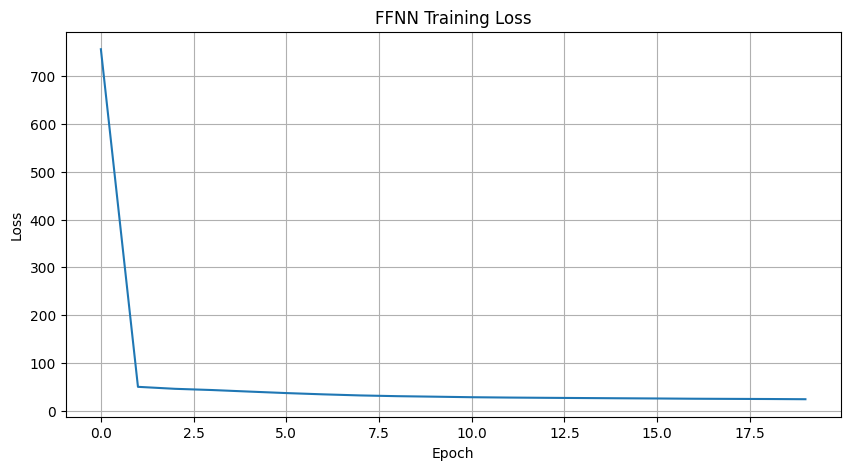

Episode 92/100: Evaluating FFNN
Episode 92/100 | Reward: -621.8327
Train MSE: 24.2774 | Train Female MSE: 6.1513
Val MSE: 72.7601 | Val Female MSE: 35.7750
Test MSE: 69.3409 | Test Female MSE: 16.2038

--------------------------------

Episode 93/100: Generating Synthetic Data
Episode 93/100: Training FFNN


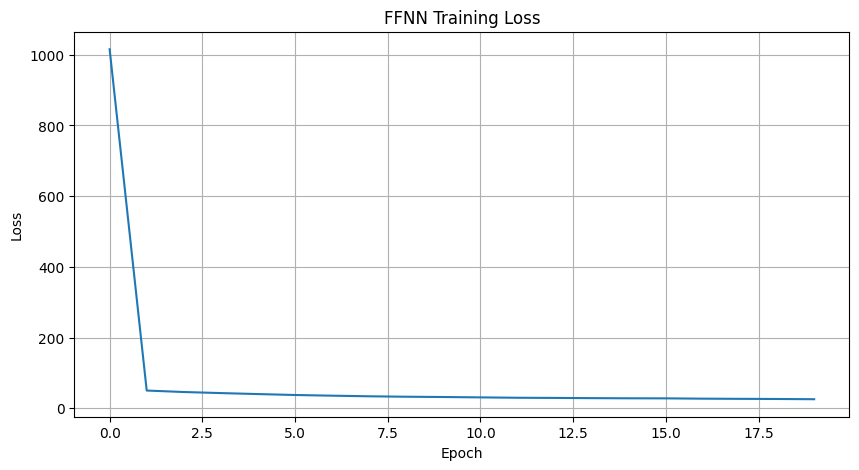

Episode 93/100: Evaluating FFNN
Episode 93/100 | Reward: -592.1636
Train MSE: 26.3755 | Train Female MSE: 6.4202
Val MSE: 69.2610 | Val Female MSE: 65.0606
Test MSE: 74.4531 | Test Female MSE: 5.7036

--------------------------------

Episode 94/100: Generating Synthetic Data
Episode 94/100: Training FFNN


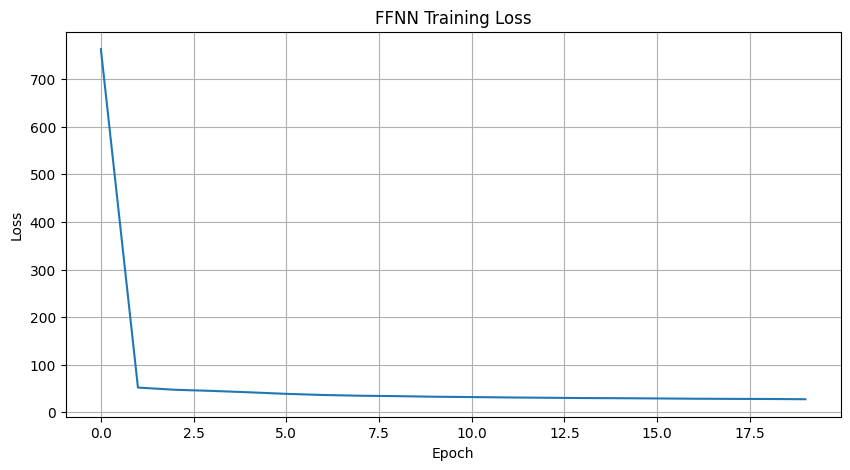

Episode 94/100: Evaluating FFNN
Episode 94/100 | Reward: -1537.1564
Train MSE: 27.2172 | Train Female MSE: 5.8155
Val MSE: 163.5234 | Val Female MSE: 37.2256
Test MSE: 58.7054 | Test Female MSE: 12.0109

--------------------------------

Episode 95/100: Generating Synthetic Data
Episode 95/100: Training FFNN


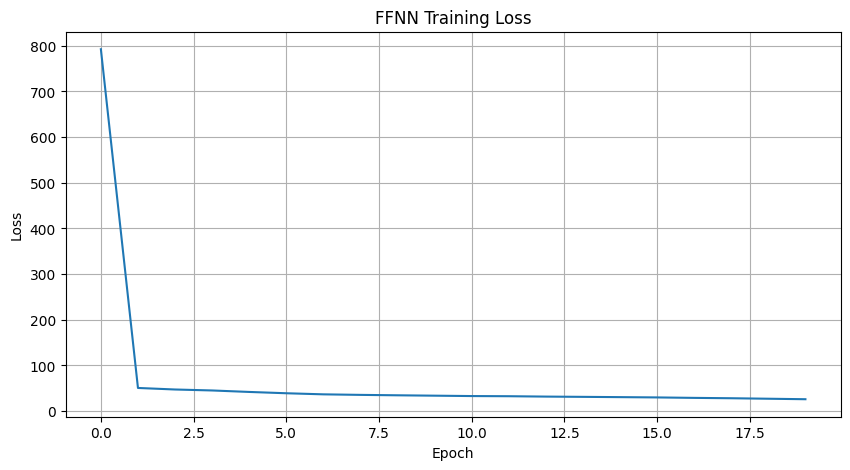

Episode 95/100: Evaluating FFNN
Episode 95/100 | Reward: -744.5313
Train MSE: 27.1769 | Train Female MSE: 7.1602
Val MSE: 85.1354 | Val Female MSE: 38.2068
Test MSE: 79.4453 | Test Female MSE: 11.9145

--------------------------------

Episode 96/100: Generating Synthetic Data
Episode 96/100: Training FFNN


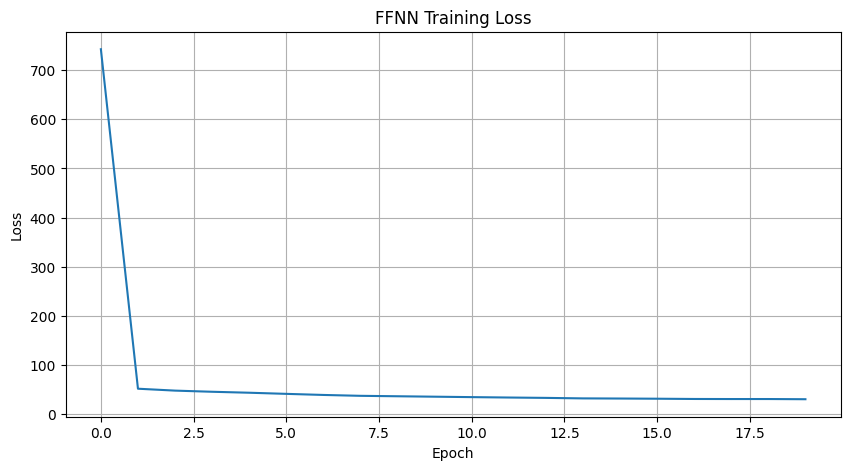

Episode 96/100: Evaluating FFNN
Episode 96/100 | Reward: -901.7451
Train MSE: 30.0148 | Train Female MSE: 7.9420
Val MSE: 100.8836 | Val Female MSE: 16.0160
Test MSE: 46.8261 | Test Female MSE: 12.3720

--------------------------------

Episode 97/100: Generating Synthetic Data
Episode 97/100: Training FFNN


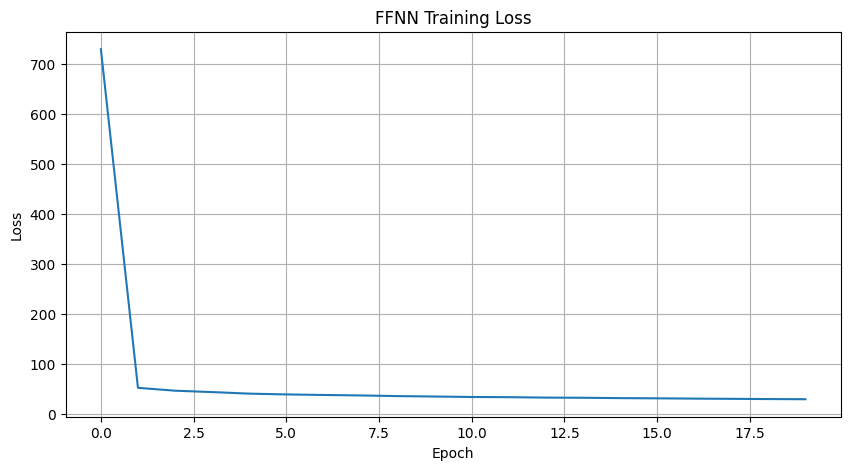

Episode 97/100: Evaluating FFNN
Episode 97/100 | Reward: -2235.7139
Train MSE: 29.9136 | Train Female MSE: 7.2313
Val MSE: 234.2667 | Val Female MSE: 77.0088
Test MSE: 47.7331 | Test Female MSE: 8.5365

--------------------------------

Episode 98/100: Generating Synthetic Data
Episode 98/100: Training FFNN


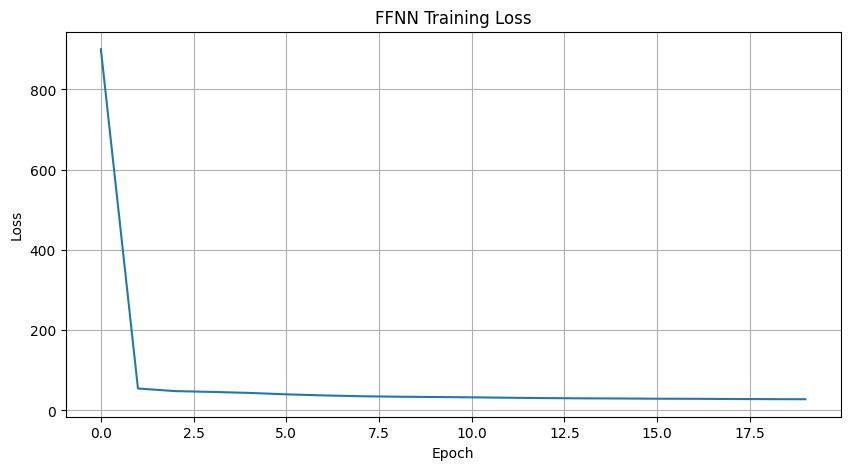

Episode 98/100: Evaluating FFNN
Episode 98/100 | Reward: -1836.8337
Train MSE: 27.0565 | Train Female MSE: 6.7756
Val MSE: 193.9440 | Val Female MSE: 224.5467
Test MSE: 62.5888 | Test Female MSE: 7.4692

--------------------------------

Episode 99/100: Generating Synthetic Data
Episode 99/100: Training FFNN


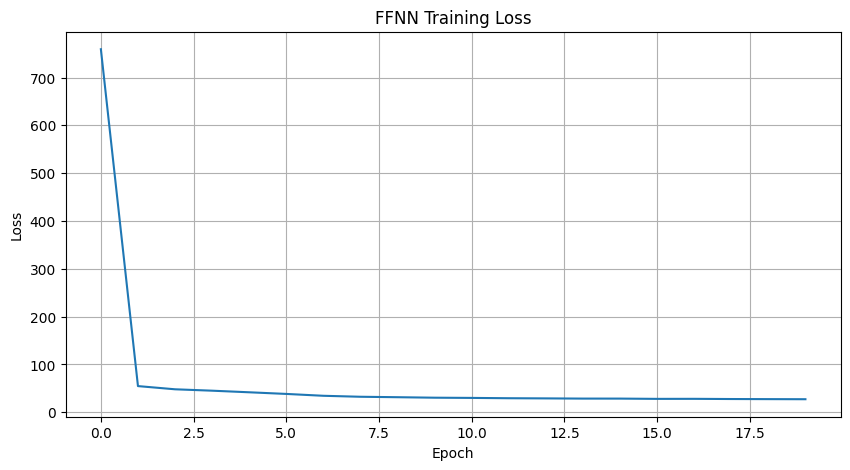

Episode 99/100: Evaluating FFNN
Episode 99/100 | Reward: -1805.6527
Train MSE: 25.8670 | Train Female MSE: 5.2671
Val MSE: 196.2771 | Val Female MSE: 34.7719
Test MSE: 53.3065 | Test Female MSE: 4.4690

--------------------------------

Episode 100/100: Generating Synthetic Data
Episode 100/100: Training FFNN


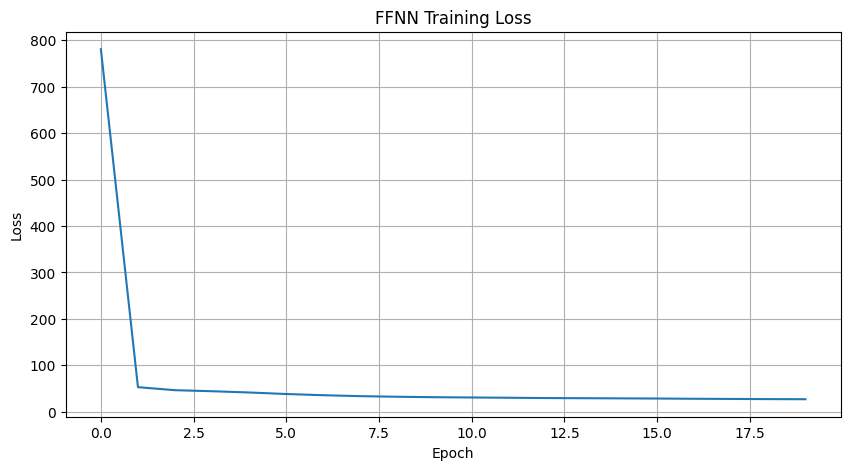

Episode 100/100: Evaluating FFNN
Episode 100/100 | Reward: -1939.6850
Train MSE: 27.2113 | Train Female MSE: 5.4956
Val MSE: 207.8369 | Val Female MSE: 166.0876
Test MSE: 52.0562 | Test Female MSE: 3.9038

--------------------------------

Metrics saved to training_metrics.json
Model saved to dqn_trained_model.pth
Model saved to ppo_trained_model.pth


In [4]:
def evaluate_ffnn(ffnn_agent, data, labels):
    if isinstance(data, (pd.DataFrame, pd.Series)):
        data = data.to_numpy()
    if isinstance(labels, (pd.DataFrame, pd.Series)):
        labels = labels.to_numpy()

    predictions = ffnn_agent.predict(data)

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    mse = mean_squared_error(labels, predictions)
    mae = mean_absolute_error(labels, predictions)

    # Optional: female-specific evaluation
    female_mask = data[:, -1] == 1
    if female_mask.sum() > 0:
        female_preds = predictions[female_mask]
        female_labels = labels[female_mask]
        female_mse = mean_squared_error(female_labels, female_preds)
    else:
        female_mse = float('nan')

    return mse, mae, female_mse



def plot_ffnn_losses(losses):
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('FFNN Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # ages in df = [27, 25, 31, 24, 26, 23]

def generate_state(df, mf_ratio, n_samples):
    timestamp = np.random.uniform(df['Timestamp'].min(), df['Timestamp'].max())
    male_female_ratio = mf_ratio 
    num_samples = n_samples
    age = np.random.uniform(24, 31)
    activity_id = np.random.choice([1, 2])
    return np.array([timestamp, male_female_ratio, num_samples, age, activity_id])


def compute_mini_reward(synthetic_data, mf_ratio):
    column_std = np.std(synthetic_data, axis=0).mean()
    gaussian_penalty = np.exp(-((mf_ratio - 0.5) ** 2) / 0.1)
    return column_std + gaussian_penalty


def train_ffnn_baseline(ffnn_agent, x_train, y_train, x_val, y_val, x_test, y_test):
    # Train on real data only
    print("\nTraining FFNN on real data only (no synthetic data)...")
    losses = ffnn_agent.train(x_train.to_numpy(), y_train.to_numpy())
    plot_ffnn_losses(losses)

    # Evaluate on all splits
    train_mse, train_mae, train_female_mse = evaluate_ffnn(ffnn_agent, x_train, y_train)
    val_mse, val_mae, val_female_mse = evaluate_ffnn(ffnn_agent, x_val, y_val)
    test_mse, test_mae, test_female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)

    # Print results
    print("\n========== FFNN Baseline (No Synthetic Data) ==========")
    print(f"Train MSE: {train_mse:.4f} | Train MAE: {train_mae:.4f} | Female MSE: {train_female_mse:.4f}")
    print(f"Val   MSE: {val_mse:.4f} | Val   MAE: {val_mae:.4f} | Female MSE: {val_female_mse:.4f}")
    print(f"Test  MSE: {test_mse:.4f} | Test  MAE: {test_mae:.4f} | Female MSE: {test_female_mse:.4f}")
    print("=======================================================\n")

    return {
        "train": (train_mse, train_mae),
        "val": (val_mse, val_mae),
        "test": (test_mse, test_mae),
    }

baseline_results = train_ffnn_baseline(ffnn_agent_og, x_train, y_train, x_val, y_val, x_test, y_test)

def train_agents(x_train, y_train, x_val, y_val, x_test, y_test,
                 dqn_agent, ppo_agent, ffnn_agent, episodes=num_episodes,
                 save_path='training_metrics.json'):

    # Normalize y arrays to shape (n, 1)
    # for var in ['y_train', 'y_val', 'y_test']:
    #     val = locals()[var]
    #     if isinstance(val, pd.Series):
    #         locals()[var] = val.to_numpy().reshape(-1, 1)
    #     elif isinstance(val, pd.DataFrame):
    #         locals()[var] = val.to_numpy()

    rewards = []
    val_accuracies = []
    test_accuracies = []
    train_accuracies = []
    val_female_accuracies = []
    test_female_accuracies = []
    train_female_accuracies = []

    synthetic_data = []
    synthetic_labels = []

    # Initial male-female ratio
    sex_female_idx = x_train.columns.get_loc('Sex - Female')
    mf_ratio = np.mean(x_train.iloc[:, sex_female_idx])
    state = generate_state(x_train, mf_ratio, 0)






    for episode in range(episodes):
        print(f"Episode {episode + 1}/{episodes}: Generating Synthetic Data")
        for i in range(synthetic_data_amount):
            if synthetic_data:
                synthetic_array = np.array(synthetic_data)
                if synthetic_array.ndim == 1:
                    synthetic_array = synthetic_array.reshape(1, -1)
                combined_array = np.vstack([x_train.to_numpy(), synthetic_array])
                combined = pd.DataFrame(combined_array, columns=x_train.columns)
            else:
                combined = x_train.copy()

            sex_female_idx = combined.columns.get_loc('Sex - Female')
            mf_ratio = np.mean(combined.iloc[:, sex_female_idx])

            # Predict actions from RL agents
            discrete_action = np.array(dqn_agent.predict(state), ndmin=1).flatten()

            # First 2 values are features: 'Sex - Female', 'Heart Rate'
            sex_value = discrete_action[0]
            heart_rate = discrete_action[1]

            # Predicted target values: Resting HR, Max HR, Weight, Height (4 values)
            predicted_targets = discrete_action[2:6]

            # Age comes from the state (4th element)
            age_from_state = state[3]

            # Combine into full target: [Resting HR, Max HR, Age, Weight, Height]
            target_values = np.insert(predicted_targets, 2, age_from_state)  # insert age at index 2
            # Resulting shape: (5,) — matches label format

            # Predict continuous features
            continuous_action = np.array(ppo_agent.predict(state), ndmin=1)  # shape (1, num_continuous_features)

            # Create synthetic feature row
            synthetic_row = np.zeros(x_train.shape[1])

            # Get column indices
            discrete_indices = x_train.columns.get_indexer(['Sex - Female', 'Heart Rate'])
            continuous_indices = x_train.columns.get_indexer(continuous_columns)

            # Assign values to synthetic row
            synthetic_row[discrete_indices[0]] = sex_value
            synthetic_row[discrete_indices[1]] = heart_rate
            synthetic_row[continuous_indices] = continuous_action.flatten()

            # Add to synthetic dataset
            synthetic_data.append(synthetic_row)
            synthetic_labels.append(target_values)

            mini_reward = compute_mini_reward(np.array(synthetic_data), mf_ratio)
            done = i == synthetic_data_amount - 1


            if done:
                print(f"Episode {episode + 1}/{episodes}: Training FFNN")
                
                ffnn_agent.reset()

                synthetic_data_np = np.array(synthetic_data)                    # (n_samples, num_features)
                synthetic_labels_np = np.array(synthetic_labels).reshape(-1, 5) # (n_samples, 5)

                combined_data = np.vstack([x_train.to_numpy(), synthetic_data_np])
                combined_labels = np.vstack([y_train, synthetic_labels_np])


                # Shuffle combined training data
                indices = np.arange(combined_data.shape[0])
                np.random.shuffle(indices)
                combined_data = combined_data[indices]
                combined_labels = combined_labels[indices]

                # Train FFNN
                losses = ffnn_agent.train(combined_data, combined_labels)
                plot_ffnn_losses(losses)

                print(f"Episode {episode + 1}/{episodes}: Evaluating FFNN")

                train_mse, train_mae, train_female_mse = evaluate_ffnn(ffnn_agent, x_train, y_train)
                val_mse, val_mae, val_female_mse = evaluate_ffnn(ffnn_agent, x_val, y_val)
                test_mse, test_mae, test_female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)

                # Reward is based on validation performance and mini reward
                reward = (accuracy_reward_multiplier * val_mse * -1) + (mini_reward)

                train_accuracies.append(train_mse)
                val_accuracies.append(val_mse)
                test_accuracies.append(test_mse)
                train_female_accuracies.append(train_female_mse)
                val_female_accuracies.append(val_female_mse)
                test_female_accuracies.append(test_female_mse)

                print(f"Episode {episode + 1}/{episodes} | Reward: {reward:.4f}")
                print(f"Train MSE: {train_mse:.4f} | Train Female MSE: {train_female_mse:.4f}")
                print(f"Val MSE: {val_mse:.4f} | Val Female MSE: {val_female_mse:.4f}")
                print(f"Test MSE: {test_mse:.4f} | Test Female MSE: {test_female_mse:.4f}")
                print("\n--------------------------------\n")


                synthetic_data = []
                synthetic_labels = []
            else:
                reward = mini_reward

            next_state = generate_state(x_train, mf_ratio, len(synthetic_data) + 1)
            dqn_agent.learn(state, discrete_action, reward, next_state, done)
            ppo_agent.learn(state, continuous_action, reward, next_state, done)

            rewards.append(reward)
            state = next_state

        metrics = {
            'rewards': rewards,
            'train_mse': train_accuracies,
            'val_mse': val_accuracies,
            'test_mse': test_accuracies,
            'train_female_mse': train_female_accuracies,
            'val_female_mse': val_female_accuracies,
            'test_female_mse': test_female_accuracies
        }


    with open(save_path, 'w') as f:
        json.dump(metrics, f)
    print(f"Metrics saved to {save_path}")

    return metrics

# Example usage
results = train_agents(x_train, y_train, x_val, y_val, x_test, y_test, dqn_agent, ppo_agent, ffnn_agent)
dqn_agent.save("dqn_trained_model.pth")
ppo_agent.save("ppo_trained_model.pth")


# Testing


In [8]:
mse, mae, female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)
print(f"Test Results | MSE: {mse} | MAE: {mae} | Female MSE: {female_mse}")

Test Results | MSE: 52.056175231933594 | MAE: 5.383599281311035 | Female MSE: 3.903790235519409


# Visualize results

In [ ]:
# visualize_training([], [])
# visualize_results(dqn_agent, ppo_agent, df)
# visualize_preprocessed_data(df)